# Final Project
## 主題: PTT中對韓劇的討論與韓劇版生態探索
成員: M124020015 李昌澤、M124020007 連心怡、M124020014 徐德諺、M124020050 陳俞安</br>



### 口頭報告連結: https://youtu.be/GhngybLshrY

## 動機與分析目的
韓劇對台灣有很大的影響力，我們時不時可以在社群媒體上看到對於不同韓劇的評價與解析，這常常勾起大眾對一部韓劇的好奇。</br>
然而，追劇是一個極度費時的活動，想要完整追完一部劇經常至少需看完16集，且通常一集長達1小時以上，因此大眾通常會依靠網路論壇的貼文與評論來判斷一部劇值不值得花費時間追下去。</br>
因此我們想透過分析PTT韓劇版中的貼文，來了解哪些韓劇在社群媒體上是具有較高討論度的，並嘗試看看能否透過分析這些貼文的內容，捕捉一部劇大致上的主題內容與劇情走向。</br>
除此之外，我們也希望能透過描繪出PTT韓劇版中用戶的社群網路圖，來找出在這個版中的關鍵評論者，藉此了解哪些用戶的評論是最受網友認可且值得參考的。

## 資料介紹
 + 來源: TarFlow，PTT韓劇版
    + 關鍵字: [心得]、[情報]、[問題]、[閒聊]、[求薦]、[分享]
    + 時間: 2021/11/01 ~ 2024/05/01
    + 資料筆數: 2036

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud
import re
import numpy as np

import jieba
import jieba.analyse

from nltk import ngrams, FreqDist


from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import time

import math
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


from functools import reduce
from collections import Counter
from pprint import pprint


from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors
from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch


import pyLDAvis
import pyLDAvis.gensim_models

import IPython.display as display
import pyvis
from pyvis.network import Network
import IPython
import random
import names
from itertools import combinations
from sklearn.feature_extraction.text import CountVectorizer

from IPython.display import display, HTML


### 匯入資料

In [ ]:
df = pd.read_csv('./Raw_Data/k_newdata.csv')
df

system_id                                             artUrl  \
0             1  https://www.ptt.cc/bbs/KoreaDrama/M.1635734288...   
1             2  https://www.ptt.cc/bbs/KoreaDrama/M.1635739609...   
2             3  https://www.ptt.cc/bbs/KoreaDrama/M.1635817399...   
3             4  https://www.ptt.cc/bbs/KoreaDrama/M.1635825806...   
4             5  https://www.ptt.cc/bbs/KoreaDrama/M.1635857832...   
...         ...                                                ...   
2031       2032  https://www.ptt.cc/bbs/KoreaDrama/M.1714557723...   
2032       2033  https://www.ptt.cc/bbs/KoreaDrama/M.1714557888...   
2033       2034  https://www.ptt.cc/bbs/KoreaDrama/M.1714564804...   
2034       2035  https://www.ptt.cc/bbs/KoreaDrama/M.1714571247...   
2035       2036  https://www.ptt.cc/bbs/KoreaDrama/M.1714578840...   

                          artTitle              artDate   artPoster  \
0            [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06     seatala   
1     [心得]HometownEP.09~12(END)(雷)  2021-11-01 12:06:47  singerjoan   
2                   [求薦]求推薦必看的韓劇清單  2021-11-02 09:43:17   cpcsteven   
3         [分享]戀慕ost4原聲帶分享｜女主一直救男主雷  2021-11-02 12:03:24     seatala   
4          [心得]柔美的細胞小將—踏實的愛情小品(有雷)  2021-11-02 20:57:10    ttocs406   
...                            ...                  ...         ...   
2031                      [心得]末日愚者  2024-05-01 18:02:00      pm2001   
2032       [心得]淚之女王—令人心疼的海仁跟賢祐中(雷)  2024-05-01 18:04:46   mininakai   
2033                  [心得]淚之女王感想總結  2024-05-01 19:59:57         n25   
2034            [心得]走向結局的淚之女王(全劇雷）  2024-05-01 21:47:25      Inborn   
2035                  [心得]淚之女王觀後心得  2024-05-01 23:53:58      By7way   

     artCatagory                                         artContent  \
0     KoreaDrama  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   
1     KoreaDrama  最後4集一口氣看完……心情很不好\n\n先辛苦演員們不是淋雨就是火燒，對！藝璃這部好可憐，什...   
2     KoreaDrama  看的韓劇不多\n目前看過最喜歡的\n第一名:我的大叔\n第二名:機智牢房生活\n第三名:機智...   
3     KoreaDrama  The ADE的安多恩演唱《戀慕》的第四首原聲帶歌曲〈I Believe〉，以感性而又細膩的...   
4     KoreaDrama  很久沒能把一部愛情劇完整的追完了\n\n之前常常看到男女主角在一起之後，\n就看不下去棄追\...   
...          ...                                                ...   
2031  KoreaDrama  結論只有一個字 悶\n完全不推薦\n除非你覺得自己正能量太多\n想要來點負面情緒\n\n劇情...   
2032  KoreaDrama  1. 我沒想到會分成三篇\n\n2. 文長。\n\n3. 本篇非黑特，謾罵編劇的朋友還請左轉...   
2033  KoreaDrama  《淚之女王》 ：想了很久才給的分，還是能給7.5/10分，很高了，佛心給分，\n 要再多給也...   
2034  KoreaDrama  平常追劇就有紀錄習慣，不過從來沒有在韓劇版上為一部劇發過一篇文以上的我沒料到竟\n然因為這部...   
2035  KoreaDrama  第一次追on檔\n雖然每次都在想說為什麼\n不等完結再一次看完\n但能夠即時跟大家討論劇情\...   

                                             artComment             e_ip  \
0     [{"cmtStatus": "推", "cmtPoster": "berrygood110...     114.32.17.60   
1     [{"cmtStatus": "推", "cmtPoster": "NickeyOrli",...     101.9.195.77   
2     [{"cmtStatus": "推", "cmtPoster": "tcchenk", "c...  150.117.222.122   
3     [{"cmtStatus": "推", "cmtPoster": "bqsehjh729",...     114.32.17.60   
4     [{"cmtStatus": "推", "cmtPoster": "dora1023", "...     42.77.59.222   
...                                                 ...              ...   
2031  [{"cmtStatus": "→", "cmtPoster": "yileng", "cm...  111.241.135.113   
2032  [{"cmtStatus": "推", "cmtPoster": "gn01988902",...   111.82.240.148   
2033  [{"cmtStatus": "推", "cmtPoster": "riss", "cmtC...     1.160.42.127   
2034  [{"cmtStatus": "推", "cmtPoster": "mininakai", ...     1.164.241.81   
2035  [{"cmtStatus": "推", "cmtPoster": "mininakai", ...  223.141.216.120   

             insertedDate dataSource  
0     2021-11-02 00:47:00        ptt  
1     2021-11-02 00:47:00        ptt  
2     2021-11-03 00:47:02        ptt  
3     2021-11-03 00:47:02        ptt  
4     2021-11-03 00:47:02        ptt  
...                   ...        ...  
2031  2024-05-02 01:57:28        ptt  
2032  2024-05-02 01:57:28        ptt  
2033  2024-05-02 01:57:28        ptt  
2034  2024-05-02 01:57:28        ptt  
2035  2024-05-02 01:57:28        ptt  

[2036 rows x 11 columns]

## 資料前處理
#### 資料清理
  + 去除無用欄位、空值
  + 移除內文網址格式

In [ ]:
clear_df = df.copy()

#去除不會用到的欄位
drop_cols = ['artUrl', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)  

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)  

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True) 
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)  

clear_df.head(20)

system_id                      artTitle              artDate  \
0           1         [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
1           2  [心得]HometownEP.09~12(END)(雷)  2021-11-01 12:06:47   
2           3                [求薦]求推薦必看的韓劇清單  2021-11-02 09:43:17   
3           4      [分享]戀慕ost4原聲帶分享｜女主一直救男主雷  2021-11-02 12:03:24   
4           5       [心得]柔美的細胞小將—踏實的愛情小品(有雷)  2021-11-02 20:57:10   
5           6              [問題]以吾之名床戲有很唐突嗎？  2021-11-03 00:23:20   
6           7                          [求薦]  2021-11-03 03:55:53   
7           8        [分享]具景伊神探vs可愛魔女音樂原聲帶分享  2021-11-03 16:43:04   
8           9            [心得]具景伊EP.01~02(雷)  2021-11-03 17:44:29   
9          10              [心得]以吾之名被老大帥到愛上他  2021-11-03 20:54:34   
10         11          [分享]Penthouse上流戰爭原聲帶  2021-11-03 23:42:20   
11         12             [心得]柔美的細胞小將大推（有雷）  2021-11-04 14:29:19   
12         13         [問題]電視常播舊韓劇有可能被當資訊落後嗎  2021-11-04 16:47:50   
13         14            [分享]酒鬼都市女人們原聲帶音樂分享  2021-11-04 17:00:12   
14         15           Re:[心得]以吾之名被老大帥到愛上他  2021-11-05 02:26:46   
15         16      [分享]達利和馬鈴薯湯OST8原聲帶音樂分享微雷  2021-11-05 10:30:42   
16         17                      [心得]告白夫妻  2021-11-05 17:01:36   
17         18             [心得]智異山EP3-4不要小看山  2021-11-05 20:49:24   
18         19            [心得]加油奉尚先生！會不會太好看了  2021-11-06 01:47:56   
19         20              [問題]付費影音平台以及韓劇推薦  2021-11-06 11:18:56   

                                           artContent  \
0   《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   
1   最後4集一口氣看完……心情很不好\n\n先辛苦演員們不是淋雨就是火燒，對！藝璃這部好可憐，什...   
2   看的韓劇不多\n目前看過最喜歡的\n第一名:我的大叔\n第二名:機智牢房生活\n第三名:機智...   
3   The ADE的安多恩演唱《戀慕》的第四首原聲帶歌曲〈I Believe〉，以感性而又細膩的...   
4   很久沒能把一部愛情劇完整的追完了\n\n之前常常看到男女主角在一起之後，\n就看不下去棄追\...   
5   好像很多人覺得以吾之名的床戲很唐突，可是我覺得還滿正常的吧？\n(或者說，唐突的地方很多，沒...   
6   每天吃飯時間會跟老公一起看劇，因為他的喜好蠻特定的\n我算是資深韓劇迷，也已經不知道有什麼類...   
7   由凍齡女神李英愛主演的《具景伊》在10/30開播\n\n在劇的開頭看到披頭散髮邋遢到不行的人...   
8   其實啊！從一開始看到這部預告的時候，就覺得特別有趣\n\n因為……平常熟悉的李英愛應該是這樣...   
9   很久沒因為追韓劇而為此發一篇文\n\n實 在 是 因 為 黑道老大 太帥了!!!!!!!!!...   
10  來開一下已經出了一段時間的原聲帶\n其實看完第三季後…原本沒想要買，但最後想說都追了那麼久，...   
11  自從看完機智醫生後就沒什麼動力看韓劇，但這部真的幫我出坑! （這部應該是我2021除\n了機...   
12  原諒我標題字數有限\n不知道該如何簡化字數來描述問題\n\n是想要問說\n能夠體諒疫情關係所...   
13  10月底有部新韓劇《酒鬼都市女人們》目前播到第 4 集\n\n女主角：李善彬飾演節目企劃、韓...   
14  終於看到同好發文了  我已經出不了坑 直接躺平好多好多天\n\n  忘了上一部這樣完全擊中心...   
15  劇情即將來到 14 集，有點虐虐的愛情看似有點轉機？\n\n前面看著他們彼此相愛卻要面對現實...   
16  有些事可以改變的\n\n但有些事一定會發生\n\n我們只能學著去接受\n\n-\n\n第一次...   
17  https://i.imgur.com/lCwUHKg.png\n這兩集簡單來說就是追查養樂...   
18  這都什麼時代了，竟然還有人拍苦命男阿信，大哥一手帶大四個弟妹，長大後的弟妹卻不知進取不停惹麻...   
19  不知能不能在這邊問這問題\n\n假設不能我再自D\n\n之前其實一直很不喜歡追劇\n\n感覺...   

                                             sentence  
0   《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續，發布，包括...  
1   最後4集一口氣看完……心情很不好。先辛苦演員們不是淋雨就是火燒，對！藝璃這部好可憐，什麼災難...  
2   看的韓劇不多，目前看過最喜歡的，第一名:我的大叔，第二名:機智牢房生活，第三名:機智醫生生活...  
3   The ADE的安多恩演唱《戀慕》的第四首原聲帶歌曲〈I Believe〉，以感性而又細膩的...  
4   很久沒能把一部愛情劇完整的追完了。之前常常看到男女主角在一起之後，，就看不下去棄追。很幸運點...  
5   好像很多人覺得以吾之名的床戲很唐突，可是我覺得還滿正常的吧？，(或者說，唐突的地方很多，沒唐...  
6   每天吃飯時間會跟老公一起看劇，因為他的喜好蠻特定的，我算是資深韓劇迷，也已經不知道有什麼類似...  
7   由凍齡女神李英愛主演的《具景伊》在10/30開播。在劇的開頭看到披頭散髮邋遢到不行的人時，不...  
8        其實啊！從一開始看到這部預告的時候，就覺得特別有趣。因為……平常熟悉的李英愛應該是這樣，  
9   很久沒因為追韓劇而為此發一篇文。實 在 是 因 為 黑道老大 太帥了!!!!!!!!!!!!...  
10  來開一下已經出了一段時間的原聲帶，其實看完第三季後…原本沒想要買，但最後想說都追了那麼久，也...  
11  自從看完機智醫生後就沒什麼動力看韓劇，但這部真的幫我出坑! （這部應該是我2021除，了機醫...  
12  原諒我標題字數有限，不知道該如何簡化字數來描述問題。是想要問說，能夠體諒疫情關係所以新劇製作...  
13  10月底有部新韓劇《酒鬼都市女人們》目前播到第 4 集。女主角：李善彬飾演節目企劃、韓善伙飾...  
14  終於看到同好發文了  我已經出不了坑 直接躺平好多好多天。  忘了上一部這樣完全擊中心臟是哪...  
15  劇情即將來到 14 集，有點虐虐的愛情看似有點轉機？。前面看著他們彼此相愛卻要面對現實的壓力...  
16  有些事可以改變的。但有些事一定會發生。我們只能學著去接受。-。第一次看把重點都放在真珠和半島...  
17   1894 年 1 月 11 日～1895 年 3 月 29 日，日帝統治＝朝鮮日治時期，是...  
18  這都什麼時代了，竟然還有人拍苦命男阿信，大哥一手帶大四個弟妹，長大後的弟妹卻不知進取不停惹麻...  
19  不知能不能在這邊問這問題。假設不能我再自D。之前其實一直很不喜歡追劇。感覺每個禮拜都在期待....

#### 斷句

In [ ]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}") # 根據標點符號將字串進行分割。

sent_df = clear_df.explode('sentence').reset_index(drop=True) # 將列表拆分成多行，並複製相應的其他資料，使得每個列表中的元素都成為一行。
sent_df.head(5)

system_id               artTitle              artDate  \
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
1          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
2          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
3          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
4          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   

                                          artContent  \
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   
1  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   
2  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   
3  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   
4  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   

                        sentence  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點  
1                     透過主要音源網站陸續  
2                             發布  
3             包括之前所有發布的原聲帶歌曲以及配樂  
4                        共計48首曲目

#### 斷詞

In [ ]:
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict("dict/user_dict.txt")

#去除句子中除了字母、數字、空白字符以外的符號，並將替換後的Series轉換為字符串類型。
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]    
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)   

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]
word_df.head(10)

Building prefix dict from c:\Users\user\Desktop\社群媒體分析\SNA Python\Final Project\dict\dict.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.ubd4b42c2f9dfbb39e2aca7e5af851d1c.cache
Loading model cost 1.125 seconds.
Prefix dict has been built successfully.


system_id               artTitle              artDate  \
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   

                                          artContent word  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   柔美  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   細胞  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   小將  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   聲帶  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   配樂  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   合輯  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   音源  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   將於  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   30  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   下午

#### 移除停用字

In [ ]:
# 匯入通用的停用字檔案
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

In [ ]:
# 移除dataframe中的停用字
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head(10)


system_id               artTitle              artDate  \
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   
0          1  [分享]柔美的細胞小將48首原聲帶歌曲有雷  2021-11-01 10:38:06   

                                          artContent word  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   柔美  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   細胞  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   小將  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   聲帶  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   配樂  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   合輯  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   音源  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   將於  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   30  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   下午

斷詞函數(轉變成後續TF-IDF使用sklearn之資料形式)

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopwords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

## 詞頻與文字雲

#### 初始詞頻

C:\Users\user\AppData\Local\Temp\ipykernel_11320\583685406.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


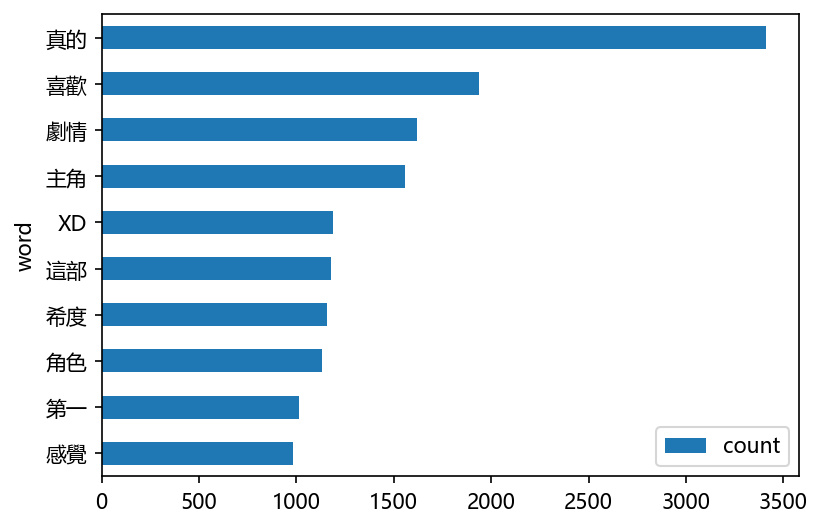

In [ ]:
freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_nostop.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 初始文字雲

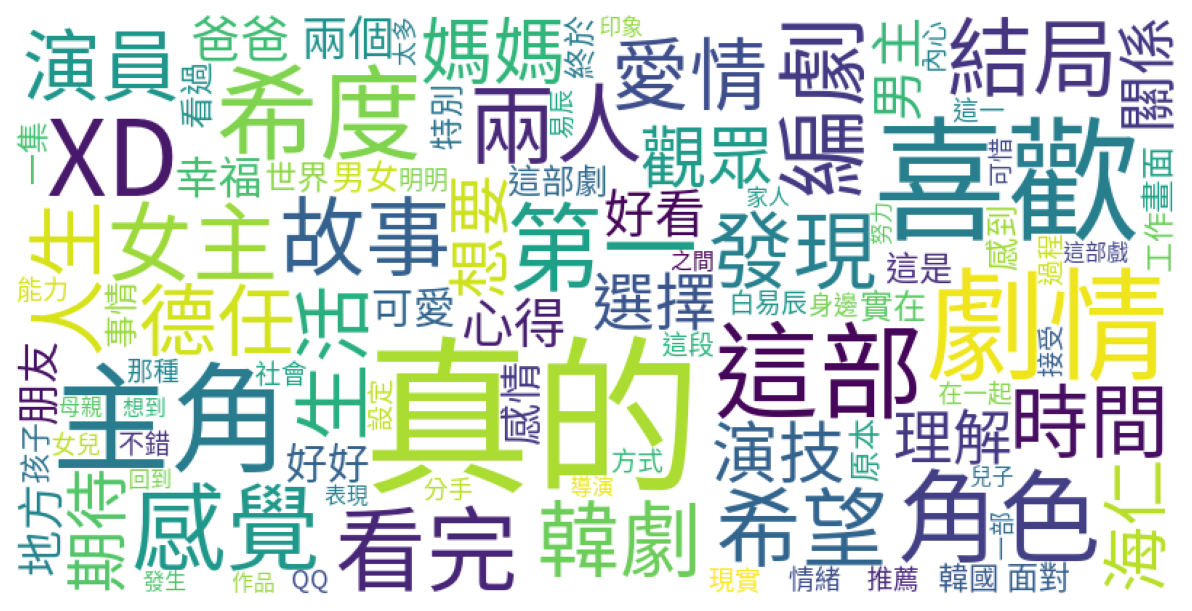

In [ ]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 100)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

#### 更新停用字

In [ ]:
# 參數形式手動加入停用字
stopwords_manual = ["真的", "媽媽", "父親", "感到", "事情", "哥哥", "家人", "爸爸", "感覺", "之間", "再次", "播出", "擁有", "第一", "女兒", "時代", "唯一", "12",
                    "生活", "透過", "父母", "變得", "最終", "學習", "介紹", "這是", "希望", "發生", "事件", "丈夫", "在一起", "講述", "展現", "朋友", "工作", "地方",
                    "代表", "世界", "公開", "時代", "現場", "兒子", "故事", "人生", "這部", "孩子", "男人", "女人", "想要", "母親", "喜歡", "結婚", "韓國", "好好",
                    "劇名", "導演", "集數", "演員", "編劇", "劇情", "角色", "播放時間", "電視台", "官網", "劇情簡介", "角色介紹", "時間", "飾演", "拍攝", "製作",
                    "XD", "預告", "真的", "第一", "媽媽", "頻道", "主角", "看完", "兩人", "發現", "選擇", "心得", "每週", "花絮", "電視劇", "企劃意圖", "EP02",
                    "QQ", "10", "EP01", "20", "16", "劇情", "播出時間", "跟播平台", "集數", "OTT", "音樂", "主要演員", "作品", "弟弟", "劇名", "能力", "特別",
                    "演技", "電影", "這一", "Netflix", "一部", "兩個", "主演", "關係", "期待", "努力", "充滿", "台灣", "這部劇", "終於", "理解", "XDD", "那種",
                    "設定", "一集", "觀眾", "原本", "實在", "方式", "這段"]
stopwords.extend(stopwords_manual)

In [ ]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]

#### 調整後詞頻

C:\Users\user\AppData\Local\Temp\ipykernel_11320\1466010102.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


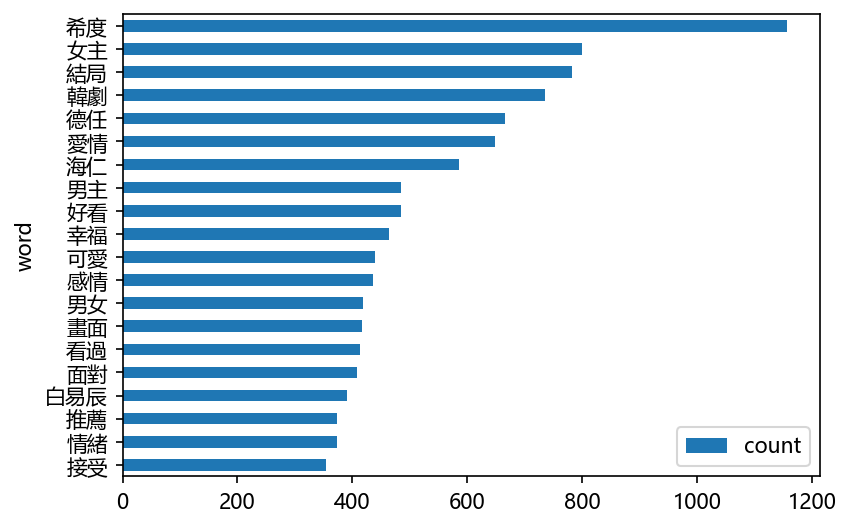

In [ ]:
freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_nostop.head(20).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 調整後文字雲

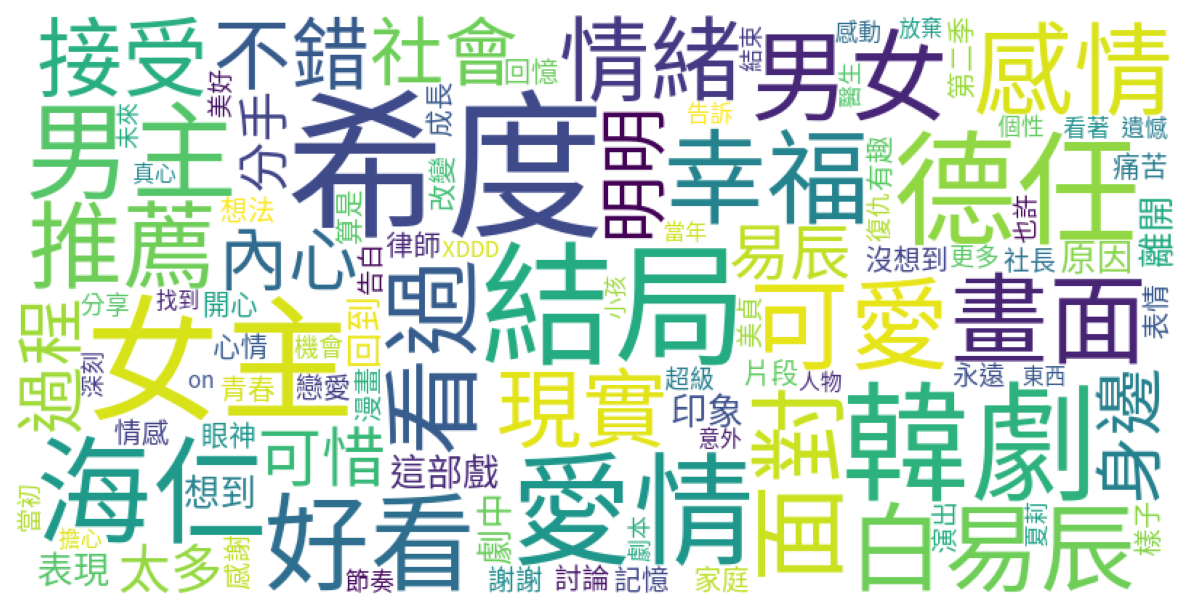

In [ ]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 100)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

### 小結

從詞彙與文字雲可看出觀眾對於韓劇討論較多的是「希度」、「德任」、「海仁」、「白易辰」、「女主」、「男主」等等。</br>
上網查詢相關資料後，我們了解
+ 「希度」與「白易辰」代表的應是韓劇「二十五。二十一」中的女主角羅希度與男主角白易辰
+ 「德任」代表的應是韓劇「衣袖紅鑲邊」中的女主角成德任

而由此文字雲我們可以推斷，PTT討論版在這個時期對韓劇「二十五。二十一」及「衣袖紅鑲邊」的討論度高。同時我們也發現，網友對韓劇的討論在劇情層面，除了常見的「男女主」與「感情線」之外，也會重點討論一部劇的「結局」。網友們也會在PTT討論版上互相「推薦」韓劇。

## Lexicon-based情緒分析

我們想透過探究貼文的正負向情緒，看看韓劇版是否有可能出現一面倒的風向存在(一定期間都是負評或都是稱讚)

In [ ]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})   # 將列名稱: name換成word，class名稱換成sentiments
# liwc_dict.head()

liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

In [ ]:
ptt_liwc_df = pd.merge(noStop_df[["artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

artDate               artTitle  \
0       2021-11-01 10:38:06  [分享]柔美的細胞小將48首原聲帶歌曲有雷   
1       2021-11-01 10:38:06  [分享]柔美的細胞小將48首原聲帶歌曲有雷   
2       2021-11-01 10:38:06  [分享]柔美的細胞小將48首原聲帶歌曲有雷   
3       2021-11-01 10:38:06  [分享]柔美的細胞小將48首原聲帶歌曲有雷   
4       2021-11-01 10:38:06  [分享]柔美的細胞小將48首原聲帶歌曲有雷   
...                     ...                    ...   
341615  2024-05-01 23:53:58           [心得]淚之女王觀後心得   
341616  2024-05-01 23:53:58           [心得]淚之女王觀後心得   
341617  2024-05-01 23:53:58           [心得]淚之女王觀後心得   
341618  2024-05-01 23:53:58           [心得]淚之女王觀後心得   
341619  2024-05-01 23:53:58           [心得]淚之女王觀後心得   

                                               artContent word sentiments  
0       《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   柔美        NaN  
1       《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   細胞        NaN  
2       《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   小將        NaN  
3       《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   聲帶        NaN  
4       《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   配樂        NaN  
...                                                   ...  ...        ...  
341615  第一次追on檔\n雖然每次都在想說為什麼\n不等完結再一次看完\n但能夠即時跟大家討論劇情\...   帶來        NaN  
341616  第一次追on檔\n雖然每次都在想說為什麼\n不等完結再一次看完\n但能夠即時跟大家討論劇情\...   更多        NaN  
341617  第一次追on檔\n雖然每次都在想說為什麼\n不等完結再一次看完\n但能夠即時跟大家討論劇情\...  捨不得        NaN  
341618  第一次追on檔\n雖然每次都在想說為什麼\n不等完結再一次看完\n但能夠即時跟大家討論劇情\...   白洪        NaN  
341619  第一次追on檔\n雖然每次都在想說為什麼\n不等完結再一次看完\n但能夠即時跟大家討論劇情\...   夫婦        NaN  

[341620 rows x 5 columns]

### 正負向情緒比例折線圖

In [ ]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()   # 計算每天分別出現了幾次的正、負面字詞
).reset_index()


 # 選取 'sentiments' 列中值為 "positive" 或 "negative" 的行，並進行排序
mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative")   
sentiment_count = sentiment_count.loc[mask] 
sentiment_count = sentiment_count.rename(columns={0: "size"}) 
sentiment_count = sentiment_count.sort_values(["artDate"])  


# 確認 artDate 是日期時間格式
sentiment_count["artDate"] = pd.to_datetime(sentiment_count["artDate"])
# 將日期時間轉換為僅包含年月日
sentiment_count["artDate"] = sentiment_count["artDate"].dt.date

sentiment_count

artDate sentiments  size
3     2021-11-01   negative    10
4     2021-11-01   positive     5
9     2021-11-01   negative    17
10    2021-11-01   positive    10
13    2021-11-02   negative     1
...          ...        ...   ...
8426  2024-05-01   positive    26
8431  2024-05-01   negative    16
8432  2024-05-01   positive    32
8437  2024-05-01   negative    12
8438  2024-05-01   positive    14

[3332 rows x 3 columns]

#### 計算比例

In [ ]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())  
)
sentiment_count

artDate sentiments  size     ratio
3     2021-11-01   negative    10  0.238095
4     2021-11-01   positive     5  0.119048
9     2021-11-01   negative    17  0.404762
10    2021-11-01   positive    10  0.238095
13    2021-11-02   negative     1  0.028571
...          ...        ...   ...       ...
8426  2024-05-01   positive    26  0.063415
8431  2024-05-01   negative    16  0.039024
8432  2024-05-01   positive    32  0.078049
8437  2024-05-01   negative    12  0.029268
8438  2024-05-01   positive    14  0.034146

[3332 rows x 4 columns]

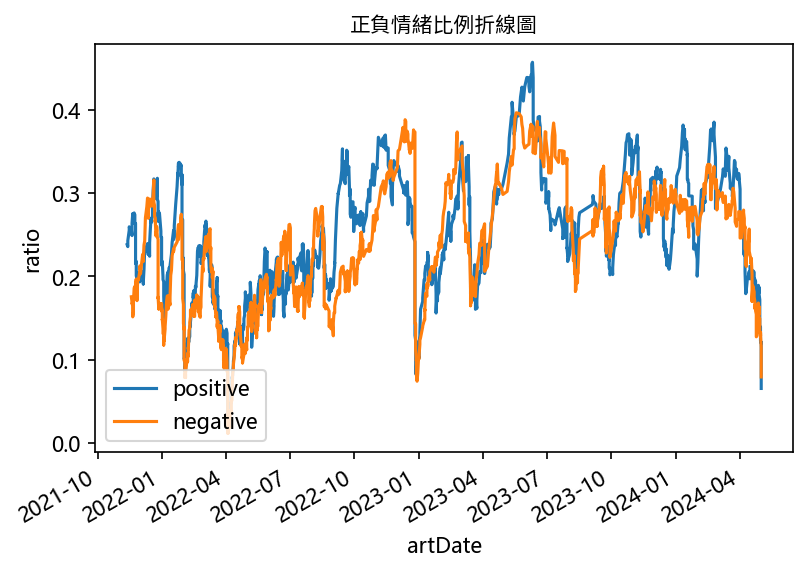

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]
fig, ax = plt.subplots()

# 使用 ax.plot() 方法時，系統就知道您想要畫折線圖

rolling_days = 30
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)
plt.show()

可以看出在韓劇版中每日貼文的正負向情緒的比例其實差異不大。

### 情緒分數折線圖

In [ ]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

ptt_sentiment_value.head()

artDate  negative   positive
0  2021-11-01      13.5   7.500000
1  2021-11-02       4.0   7.666667
2  2021-11-03       6.2   5.666667
3  2021-11-04       4.0   5.666667
4  2021-11-05       8.5  13.333333

In [ ]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

artDate  negative   positive  sentiment_value
0  2021-11-01      13.5   7.500000        -6.000000
1  2021-11-02       4.0   7.666667         3.666667
2  2021-11-03       6.2   5.666667        -0.533333
3  2021-11-04       4.0   5.666667         1.666667
4  2021-11-05       8.5  13.333333         4.833333

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

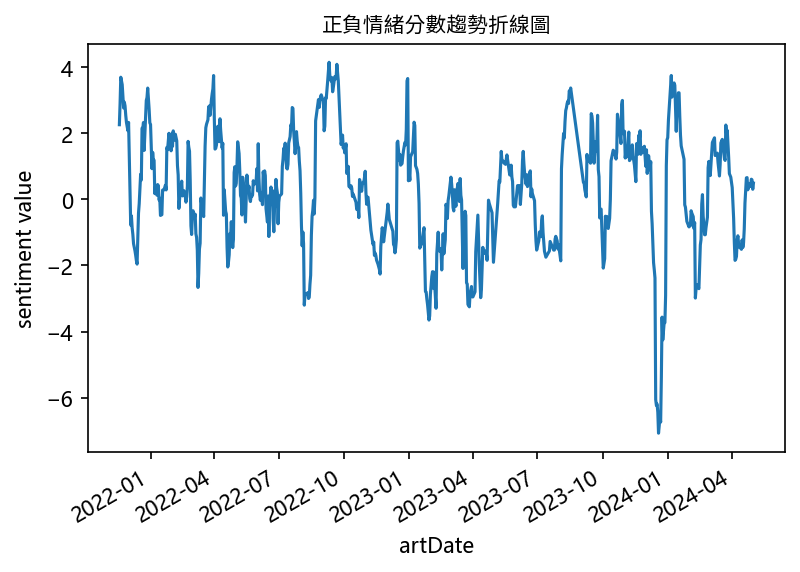

In [ ]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 情緒代表字

接著我們透過情緒代表字來找出導致情緒分數波動的主要詞彙

In [ ]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

word sentiments  size
1324   愛情     affect   649
1325   愛情   positive   649
1031   幸福     affect   464
1032   幸福   positive   464
552    可愛   positive   439
...   ...        ...   ...
902    嬉鬧     affect     1
2350   眾怒     affect     1
2351   眾怒      anger     1
2352   眾怒   negative     1
2443   粗心   negative     1

[3279 rows x 3 columns]

C:\Users\user\AppData\Local\Temp\ipykernel_11320\3412964808.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\user\AppData\Local\Temp\ipykernel_11320\3412964808.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

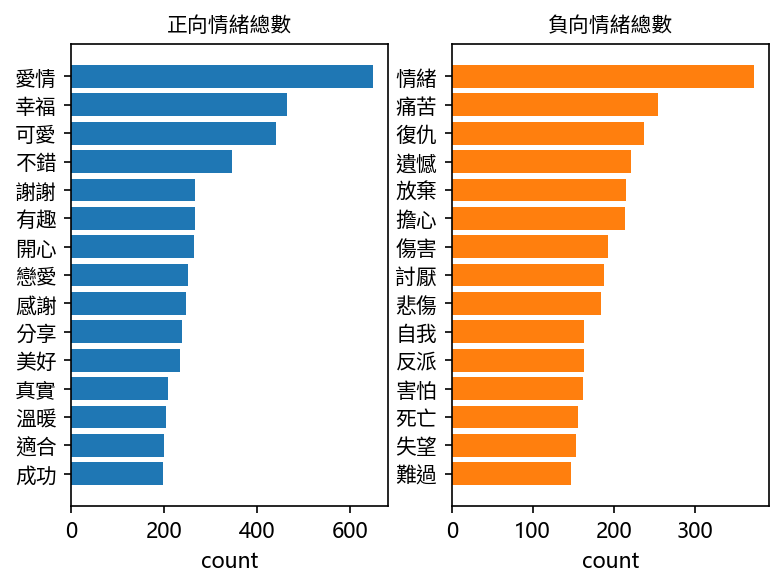

In [ ]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

#### 移除不適當的情緒字


In [ ]:
# 設定要移除的字詞列表
words_to_remove = ['作品','感謝','謝謝']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

artDate               artTitle  \
0  2021-11-01 10:38:06  [分享]柔美的細胞小將48首原聲帶歌曲有雷   
1  2021-11-01 10:38:06  [分享]柔美的細胞小將48首原聲帶歌曲有雷   
2  2021-11-01 10:38:06  [分享]柔美的細胞小將48首原聲帶歌曲有雷   
3  2021-11-01 10:38:06  [分享]柔美的細胞小將48首原聲帶歌曲有雷   
4  2021-11-01 10:38:06  [分享]柔美的細胞小將48首原聲帶歌曲有雷   

                                          artContent word sentiments  
0  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   柔美        NaN  
1  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   細胞        NaN  
2  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   小將        NaN  
3  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   聲帶        NaN  
4  《柔美的細胞小將》原聲帶與配樂的合輯音源將於30日下午6點，透過主要音源網站陸續\n發布，包...   配樂        NaN

C:\Users\user\AppData\Local\Temp\ipykernel_11320\1465679712.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\user\AppData\Local\Temp\ipykernel_11320\1465679712.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

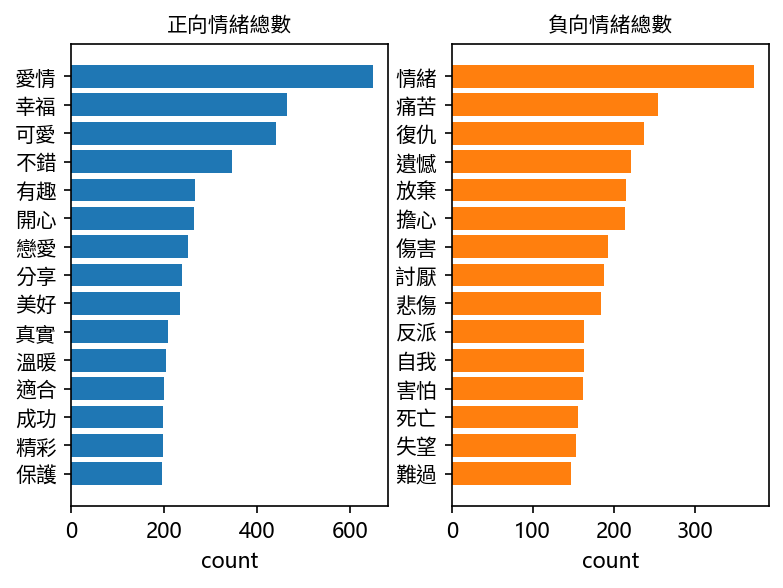

In [ ]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 小結

我們可以發現正向情緒字除了「愛情」、「幸福」、「戀愛」等與劇情本身相關的詞彙，也包含不少「可愛」、「不錯」、「有趣」等網友對於韓劇或其演員的正向評價。</br>
然而，出乎我們意料的，對負向情緒而言，則多是與負面劇情走向相關的詞彙，跟一部劇負評相關詞彙僅出現「失望」。<br>
除此之外也可以觀察到，前十大正向詞彙出現的數量幾乎是負向的兩倍。

## CKIP

嘗試找出討論度較高的韓劇角色

In [ ]:
# 將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("./Raw_Data/data")
pos = POS("./Raw_Data/data")
ner = NER("./Raw_Data/data")

定義文字清理的相關function

In [ ]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [ ]:
# 自定義辭典
with open('./dict/user_dict.txt', encoding='utf-8') as f:
    lines = f.read().splitlines()

dict_user_define = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict_user_define)
print(dictionary2)

In [ ]:
# 將詞性標註的結果轉換為列表形式，以便後續的處理和分析。
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens


# 將命名實體識別的結果轉換為列表形式，以便後續的處理和分析。
def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities


# 對資料框架中的每個文檔進行自然語言處理（NLP），並將處理結果組織成三個資料表：詞性標註表、命名實體識別表和句子表。
def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [ ]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

In [ ]:
pos_table.head() # word pos 列表

In [ ]:
entity_table.head() # word entity 列表

In [ ]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 3262篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 3256篇有抓到ner

In [ ]:
# 將文章存成csv
pos_table.to_csv('./Raw_Data/Cleaned/pos_table_Korean_Drama.csv', index = False)
entity_table.to_csv('./Raw_Data/Cleaned/entity_table_Korean_Drama.csv', index = False)
sentence_table.to_csv('./Raw_Data/Cleaned/sentence_table_Korean_Drama.csv', index = False)

In [ ]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("Raw_Data/Cleaned/pos_table_Korean_Drama.csv") 
entity_table = pd.read_csv("Raw_Data/Cleaned/entity_table_Korean_Drama.csv") 
sentence_table = pd.read_csv("Raw_Data/Cleaned/sentence_table_Korean_Drama.csv") 

### 探索分析-NER

尋找討論度較高的實體

In [ ]:
entity_table['ner'].unique()

array(['WORK_OF_ART', 'CARDINAL', 'ORDINAL', 'PERSON', 'GPE', 'DATE',
       'LOC', 'TIME', 'FAC', 'ORG', 'LANGUAGE', 'EVENT', 'NORP',
       'PRODUCT', 'QUANTITY', 'PERCENT', 'LAW', 'MONEY'], dtype=object)

In [ ]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

ner  count
13    PERSON  27891
0   CARDINAL   5339
1       DATE   3103
10   ORDINAL   2861
4        GPE   2774
11       ORG    957
16      TIME    648
3        FAC    440
7        LOC    389
9       NORP    388

C:\Users\user\AppData\Local\Temp\ipykernel_11320\2020886781.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


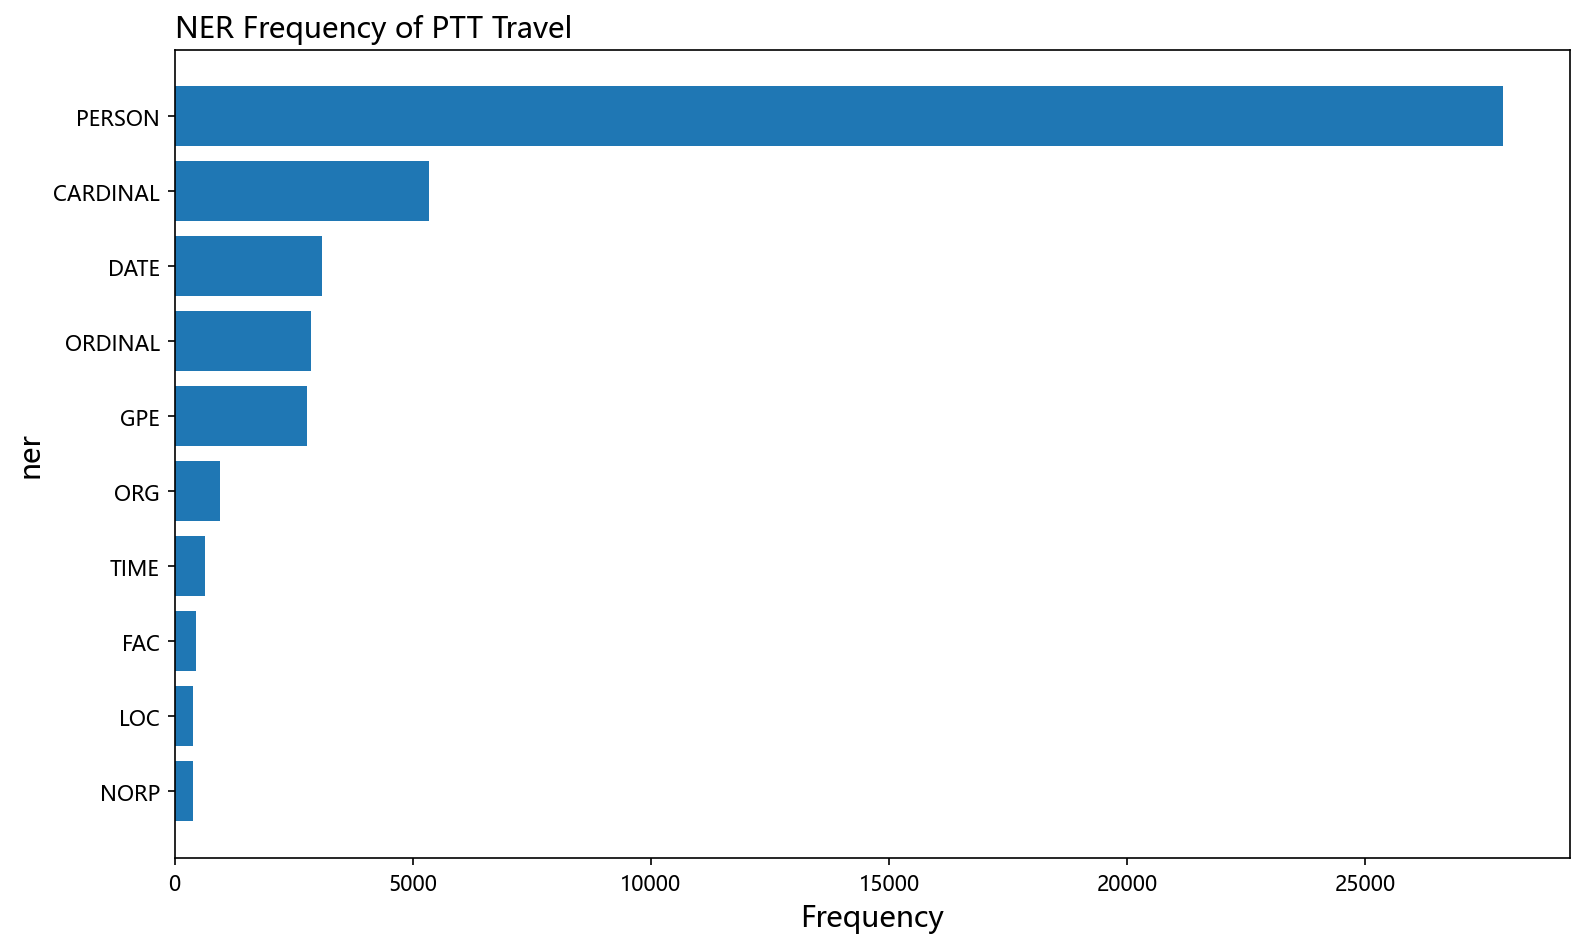

In [ ]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Travel',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

因為劇集討論多會提到人名(主角、配角等等)，導致PERSON佔的比例最高。因此我們決定看看有那些人名常被提及。

#### 涉及到的人名 - PERSON

C:\Users\user\AppData\Local\Temp\ipykernel_11320\1203258411.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


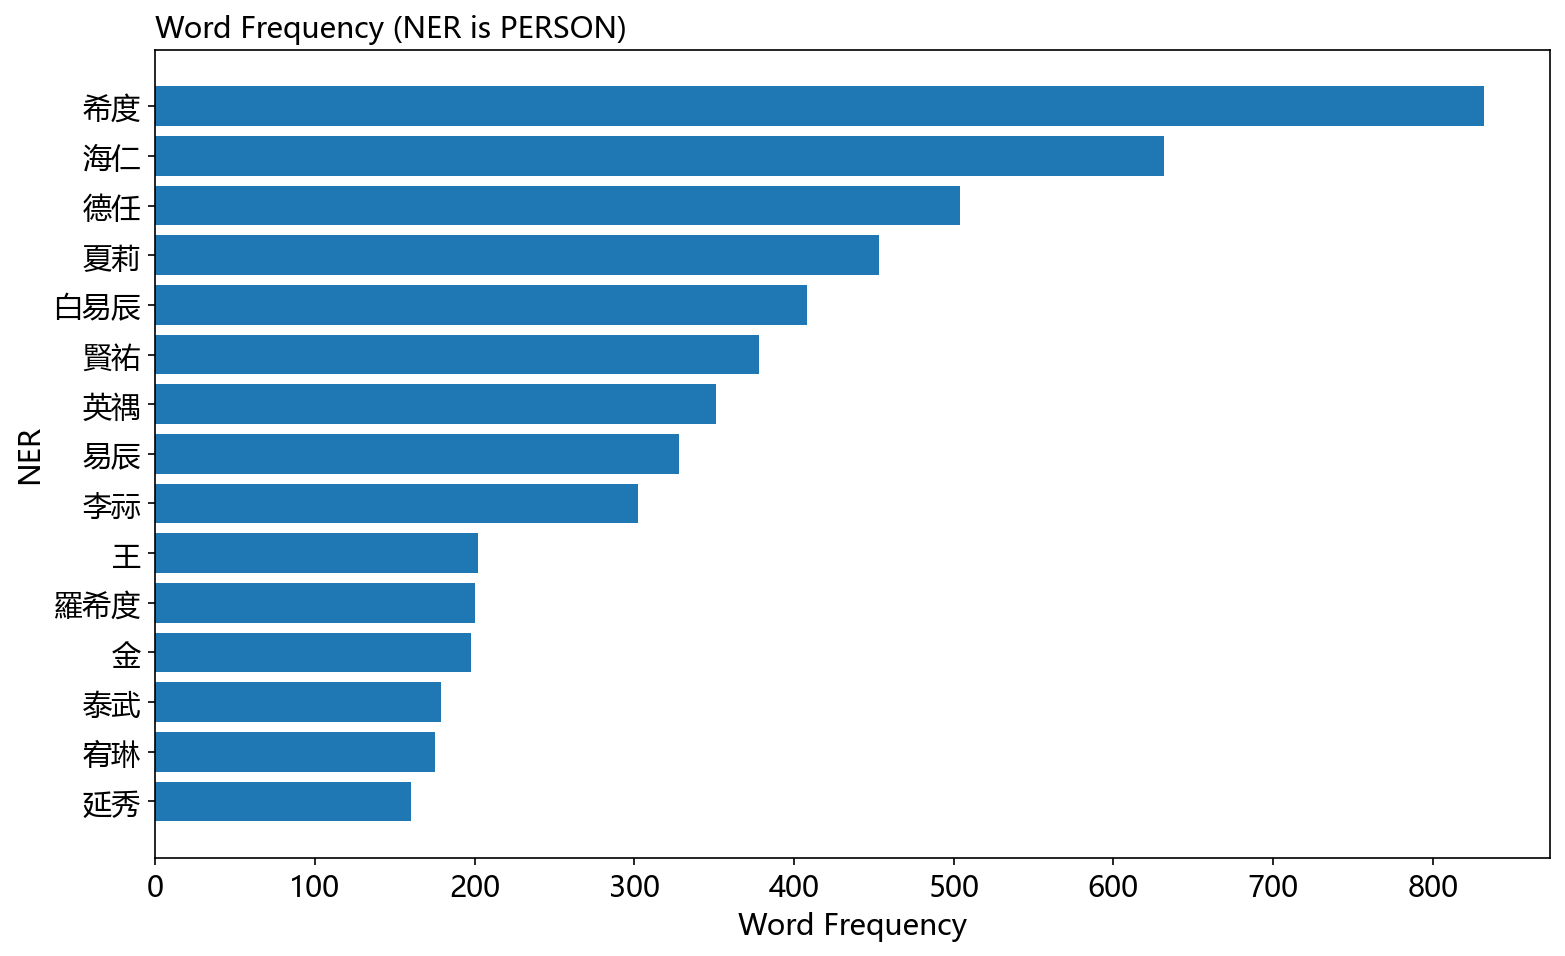

In [ ]:
# 篩選ner為PERSON的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(15).reset_index()


# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
word = ner_count['word']
count = ner_count['count']


fig, ax = plt.subplots(figsize =(12, 7))
ax.fontsize = 32
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)

# 設置刻度標籤的字體大小
ax.tick_params(axis='both', which='major', labelsize=14)

fig.show()

最常出現的人名是「希度」，且與其他人名出現頻率差異極大。</br>
從人名也可以看出網友討論哪幾部劇比較熱烈:
+ 二十五。二十一: 白易辰、羅希度與高宥琳
+ 淚之女王: 白賢祐與洪海仁
+ 衣袖紅鑲邊: 成德任與李祘
+ 社內相親: 夏莉與金泰武
+ 非常律師禹英禑: 英禑

### 探索分析 - POS

In [ ]:
pos_table['pos'].unique()

pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

pos   count
18   Na  188354
5     D  136118
46   VH   76600
7    DE   72864
40   VC   67435
30   Nh   49303
32    P   43664
19   Nb   30731
28   Nf   29826
4   Cbb   29563
43   VE   27473
34  SHI   26990

C:\Users\user\AppData\Local\Temp\ipykernel_11320\2478466374.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


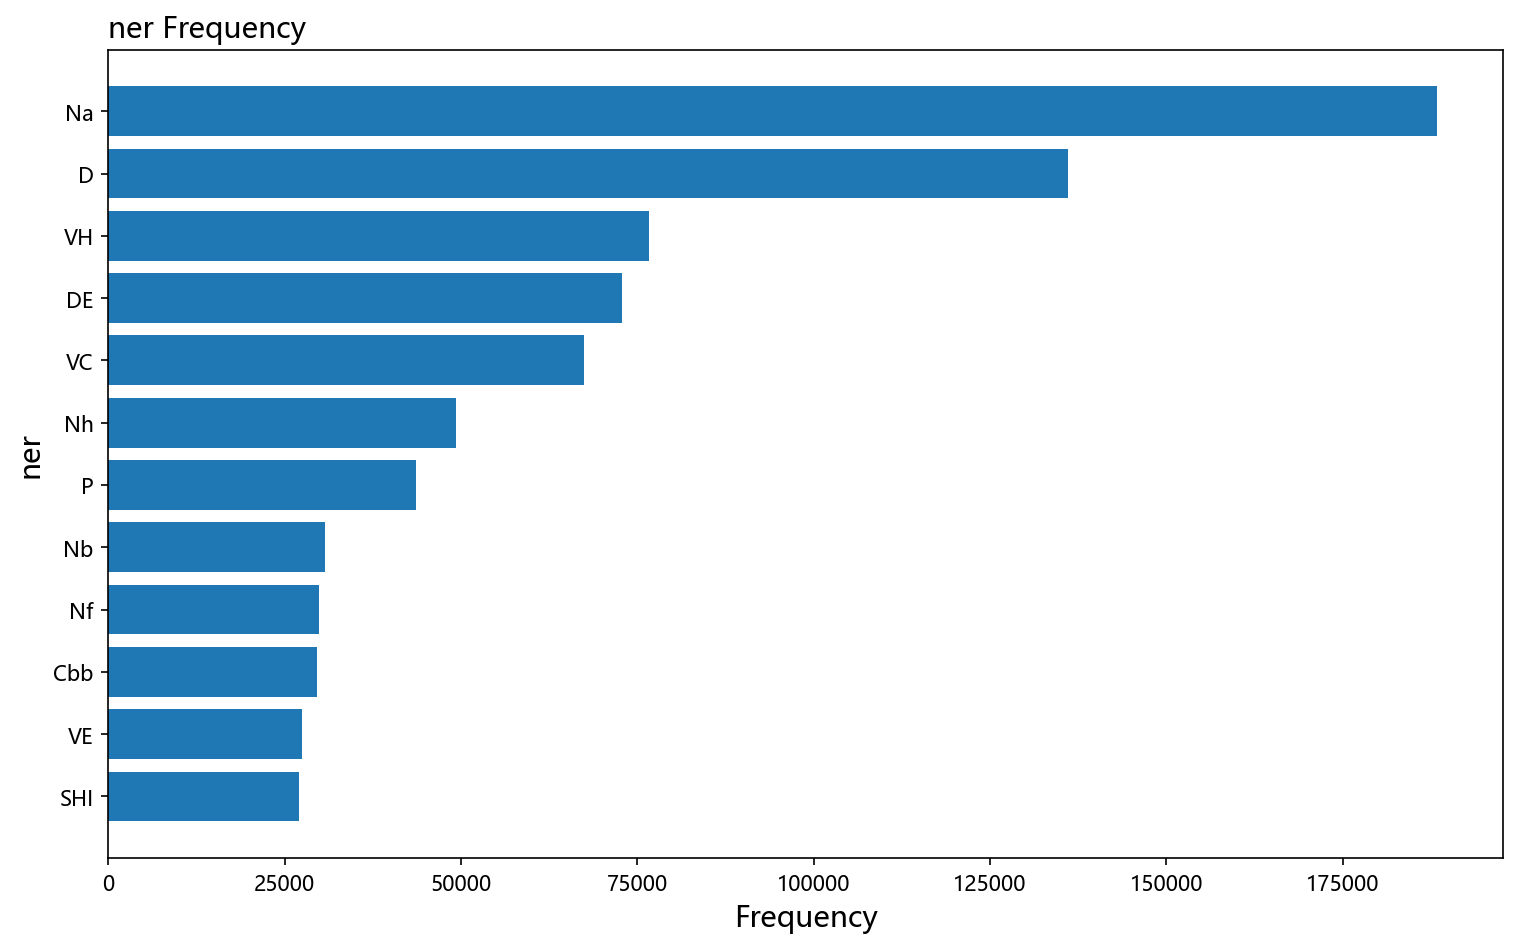

In [ ]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

#### 涉及到的名詞 -Noun
  + 找出大家在韓劇版討論的相關名詞，探索大家的關注焦點
  + 底下以Na(普通名詞)進行探索

In [ ]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

word  count
2103   德任    801
3640   海仁    702
2505   易辰    506
4056  白易辰    458
929    夏莉    449
4899   賢祐    392
4589   英禑    333
3069   李祘    331
3840    王    313
4396    羅    258

雖然Na是數量最多的詞彙類型，但是因為Na為"普通名詞"，探索出的內容看不出探討的相關方向<br>
因此以Nb(專有名詞)進行探討

C:\Users\user\AppData\Local\Temp\ipykernel_11320\1120426065.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


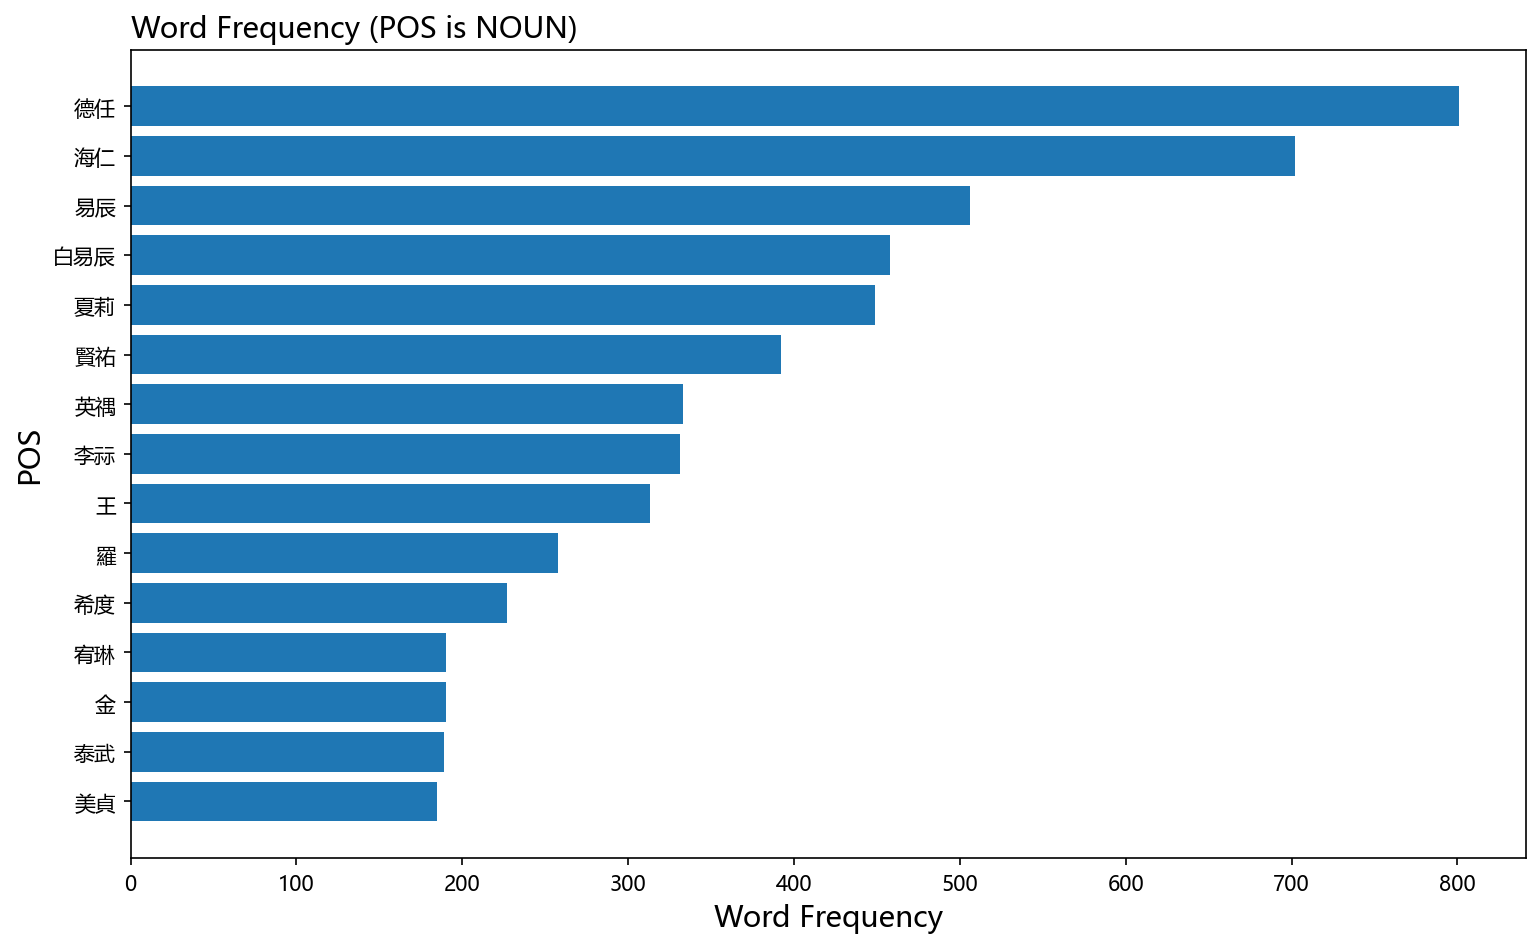

In [ ]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Microsoft Yahei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

與NER的PERSON高度類似，幾乎都是主角名稱

## Pairwise correlation

接著我們想要探索在網友的討論中有哪些詞彙會跟隨這些韓劇的主角們一起出現

In [ ]:
data_cor = clear_df.copy()
data_cor

system_id                                           sentence  \
0             1  柔美的細胞小將原聲帶與配樂的合輯音源將於日下午點透過主要音源網站陸續發布包括之前所有發布的原...   
1             2  最後集一口氣看完心情很不好先辛苦演員們不是淋雨就是火燒對藝璃這部好可憐什麼災難慘狀她都有份兒...   
2             3  看的韓劇不多目前看過最喜歡的第一名我的大叔第二名機智牢房生活第三名機智醫生生活第一季請回答這...   
3             4  的安多恩演唱戀慕的第四首原聲帶歌曲以感性而又細膩的嗓音完美呈現這首歌曲是首表達對一個男人有著...   
4             5  很久沒能把一部愛情劇完整的追完了之前常常看到男女主角在一起之後就看不下去棄追很幸運點開這部看...   
...         ...                                                ...   
2031       2032  結論只有一個字悶完全不推薦除非你覺得自己正能量太多想要來點負面情緒劇情沒有甚麼高潮迭起畢竟故...   
2032       2033  我沒想到會分成三篇文長本篇非黑特謾罵編劇的朋友還請左轉非常感謝以下有淚之女王全劇雷賢祐是在充...   
2033       2034  淚之女王想了很久才給的分還是能給分很高了佛心給分要再多給也沒辦法絕對不能不盛讚雙金無論個人魅...   
2034       2035  平常追劇就有紀錄習慣不過從來沒有在韓劇版上為一部劇發過一篇文以上的我沒料到竟然因為這部連發三...   
2035       2036  第一次追檔雖然每次都在想說為什麼不等完結再一次看完但能夠即時跟大家討論劇情是最特別的一次追劇...   

                                                   word  
0     柔美 細胞 小將 聲帶 配樂 合輯 音源 將於日 下午 音源 網站 陸續 發布 包括 發布 ...  
1     一口氣 心情 辛苦 淋雨 火燒 對藝璃 可憐 災難 慘狀 有份兒 中毒 吐血 紮紮實實 血汗...  
2     韓劇 不多 看過 大叔 第二名 機智 牢房 第三名 機智 醫生 第一季 回答 這四部 整部戲...  
3     多恩 演唱 戀慕 第四首 聲帶 歌曲 感性 細膩 嗓音 完美 呈現 這首 歌曲 表達 依戀 ...  
4     很久 沒能 愛情劇 完整 追完 男女 棄追 幸運 點開 看著 柔美 一場 戀愛 穿插 可愛 ...  
...                                                 ...  
2031  結論 字悶 推薦 能量 太多 來點 負面 情緒 高潮迭起 朝顯 半島 行星 大部分 腳色 討...  
2032  沒想到 分成 三篇 文長 本篇非 黑特 謾罵 還請 左轉 感謝 淚之女王 全劇 雷賢 愛的 ...  
2033  淚之女王 才給 給分 佛心 給分 多給 沒辦法 盛讚 雙金 魅力 化學 效應 超強 金秀賢 ...  
2034  平常 追劇 紀錄 習慣 韓劇 版上 一部劇 發過 一篇文 料到 連發 三文 洗版 平常 潛水...  
2035  追檔 每次 不等 完結 再一次 即時 討論 追劇 體驗 防雷 淚之女王 夫妻 三年 種種 因...  

[2036 rows x 3 columns]

In [ ]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

一句  一步  不想  不行  不錯  世子  中殿  也許  互動  交往  ...  霸凌  青春  面前  面對  韓劇  題材  類似  \
0      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1      1   0   0   0   0   0   0   0   0   0  ...   0   0   1   4   0   0   0   
2      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   1   1   0   0   
3      0   0   0   0   0   2   0   0   0   0  ...   0   0   0   0   0   0   0   
4      0   0   0   0   1   0   0   0   0   0  ...   0   0   0   0   0   0   0   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
2031   0   0   0   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2032   1   1   2   1   1   0   0   0   0   1  ...   0   0   0   3   0   0   0   
2033   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   1   0   0   
2034   0   1   1   0   3   0   0   0   0   0  ...   0   0   1   1   2   0   0   
2035   0   0   0   0   0   0   0   1   0   0  ...   0   0   0   1   0   1   0   

      高鎮  魅力  默默  
0      0   0   0  
1      0   0   0  
2      0   0   0  
3      0   0   1  
4      0   0   0  
...   ..  ..  ..  
2031   0   0   0  
2032   0   0   1  
2033   0   3   0  
2034   0   2   0  
2035   0   0   0  

[2036 rows x 300 columns]

In [ ]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

word1        一句        一步        不想        不行        不錯        世子  \
0      一句  1.000000  0.107463  0.199282  0.121421  0.006530  0.002520   
1      一步  0.107463  1.000000  0.040418  0.056519  0.017436  0.008608   
2      不想  0.199282  0.040418  1.000000  0.192046  0.051242  0.120137   
3      不行  0.121421  0.056519  0.192046  1.000000  0.097042  0.106820   
4      不錯  0.006530  0.017436  0.051242  0.097042  1.000000  0.040181   
..    ...       ...       ...       ...       ...       ...       ...   
295    題材  0.042830  0.005082  0.017653  0.022410  0.146170 -0.013746   
296    類似  0.013073 -0.029102  0.058101  0.023221  0.087444 -0.002808   
297    高鎮  0.000227 -0.011998  0.031625  0.112436  0.036082 -0.006604   
298    魅力  0.073877  0.110376  0.056773  0.091591  0.200120  0.100223   
299    默默  0.145353  0.111100  0.121533  0.125619  0.083706  0.104513   

           中殿        也許        互動  ...        霸凌        青春        面前  \
0    0.010655  0.125245  0.043651  ...  0.013501  0.038565  0.107326   
1    0.054732  0.104133  0.043026  ...  0.028447  0.026428  0.058676   
2    0.091098  0.093231  0.058677  ... -0.023150  0.040515  0.204925   
3    0.048797  0.083982  0.044892  ... -0.025706  0.034843  0.063875   
4   -0.011367  0.009013  0.184781  ...  0.080591 -0.025376  0.005360   
..        ...       ...       ...  ...       ...       ...       ...   
295 -0.014242  0.010853  0.069470  ...  0.215457  0.013222 -0.011082   
296 -0.017569  0.060107  0.041048  ...  0.027464 -0.008289  0.016783   
297 -0.005598  0.079646 -0.015555  ... -0.009083 -0.002384  0.144579   
298  0.044315  0.056658  0.122326  ...  0.004225  0.048896  0.062054   
299  0.110000  0.252559  0.083926  ...  0.036097  0.031729  0.211047   

           面對        韓劇        題材        類似        高鎮        魅力        默默  
0    0.196860  0.002997  0.042830  0.013073  0.000227  0.073877  0.145353  
1    0.133685  0.019457  0.005082 -0.029102 -0.011998  0.110376  0.111100  
2    0.182968  0.019070  0.017653  0.058101  0.031625  0.056773  0.121533  
3    0.105809  0.068282  0.022410  0.023221  0.112436  0.091591  0.125619  
4    0.037745  0.130367  0.146170  0.087444  0.036082  0.200120  0.083706  
..        ...       ...       ...       ...       ...       ...       ...  
295  0.040445  0.252318  1.000000  0.087689  0.026160  0.106705  0.072357  
296  0.039290  0.112843  0.087689  1.000000  0.001365  0.009808  0.037428  
297  0.028161 -0.022600  0.026160  0.001365  1.000000  0.033002  0.127293  
298  0.093452  0.164775  0.106705  0.009808  0.033002  1.000000  0.144176  
299  0.161039  0.027063  0.072357  0.037428  0.127293  0.144176  1.000000  

[300 rows x 301 columns]

In [ ]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

word1 word2       cor
27991    後宮    德任  0.890270
27393    德任    後宮  0.890270
49853    夏莉    泰武  0.860199
16066    泰武    夏莉  0.860199
27970    宮女    德任  0.836520
21093    德任    宮女  0.836520
63053    夏莉    社長  0.833366
16110    社長    夏莉  0.833366
23243    易辰    希度  0.824834
42977    希度    易辰  0.824834

#### 和德任、希度最相關的10個詞彙

從前面的結果，我們挑選分屬兩部劇的主角希度與德任進行分析

In [ ]:
ice_sum = word_cor_df[(word_cor_df["word1"] == "德任")].sort_values(by = ['cor'], ascending = False).head(10)
taste_sum = word_cor_df[(word_cor_df["word1"] == "希度")].sort_values(by = ['cor'], ascending = False).head(10)

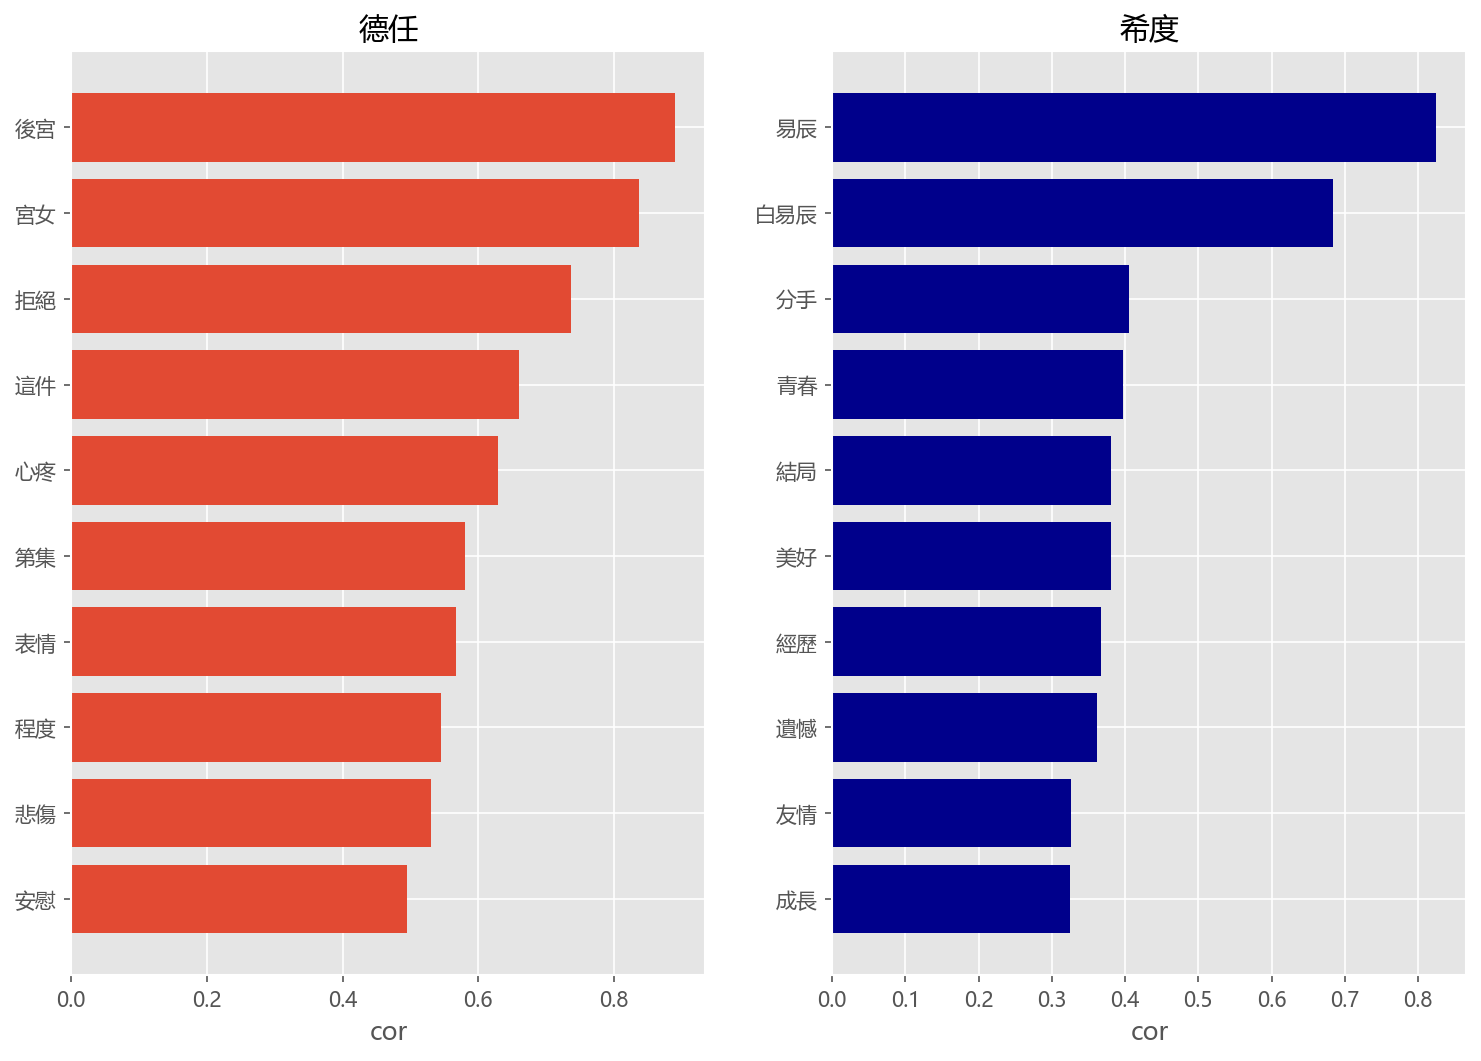

In [ ]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('德任')
plt.xlabel('cor')
plt.barh(ice_sum['word2'],ice_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('希度')
plt.xlabel('cor')
plt.barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

從上面這張表可以發現，德任與希度雖然同為女主角，但隨著劇種的不同，網友在討論他們時使用的相關詞彙有很大的差異。<br />
衣袖紅鑲邊的女主德任由於其宮女身分，故與「後宮」、「宮女」二詞最相關，同時從「心疼」、「悲傷」、「安慰」也能看出其較為淒慘的劇中故事。<br />
二十五。二十一的女主希度則是與男主「白易辰」較為相關，而從「青春」、「美好」、「友情」、「成長」幾個相關詞也可以判斷這部劇是青春題材的。

### 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

接著我們嘗試以關係圖找出整體而言詞頻較高且相關性高的詞彙

In [ ]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(100).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [ ]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

word1 word2       cor
0      好看    不錯  0.305231
1      永遠    也許  0.302592
2      情感    內心  0.361310
3      希度    分手  0.404884
4      接受    分手  0.307920
..    ...   ...       ...
165    告訴    面對  0.314678
166    幸福    面對  0.311231
167    成長    面對  0.326404
168    痛苦    面對  0.424556
169    瞬間    面對  0.325257

[170 rows x 3 columns]

In [ ]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

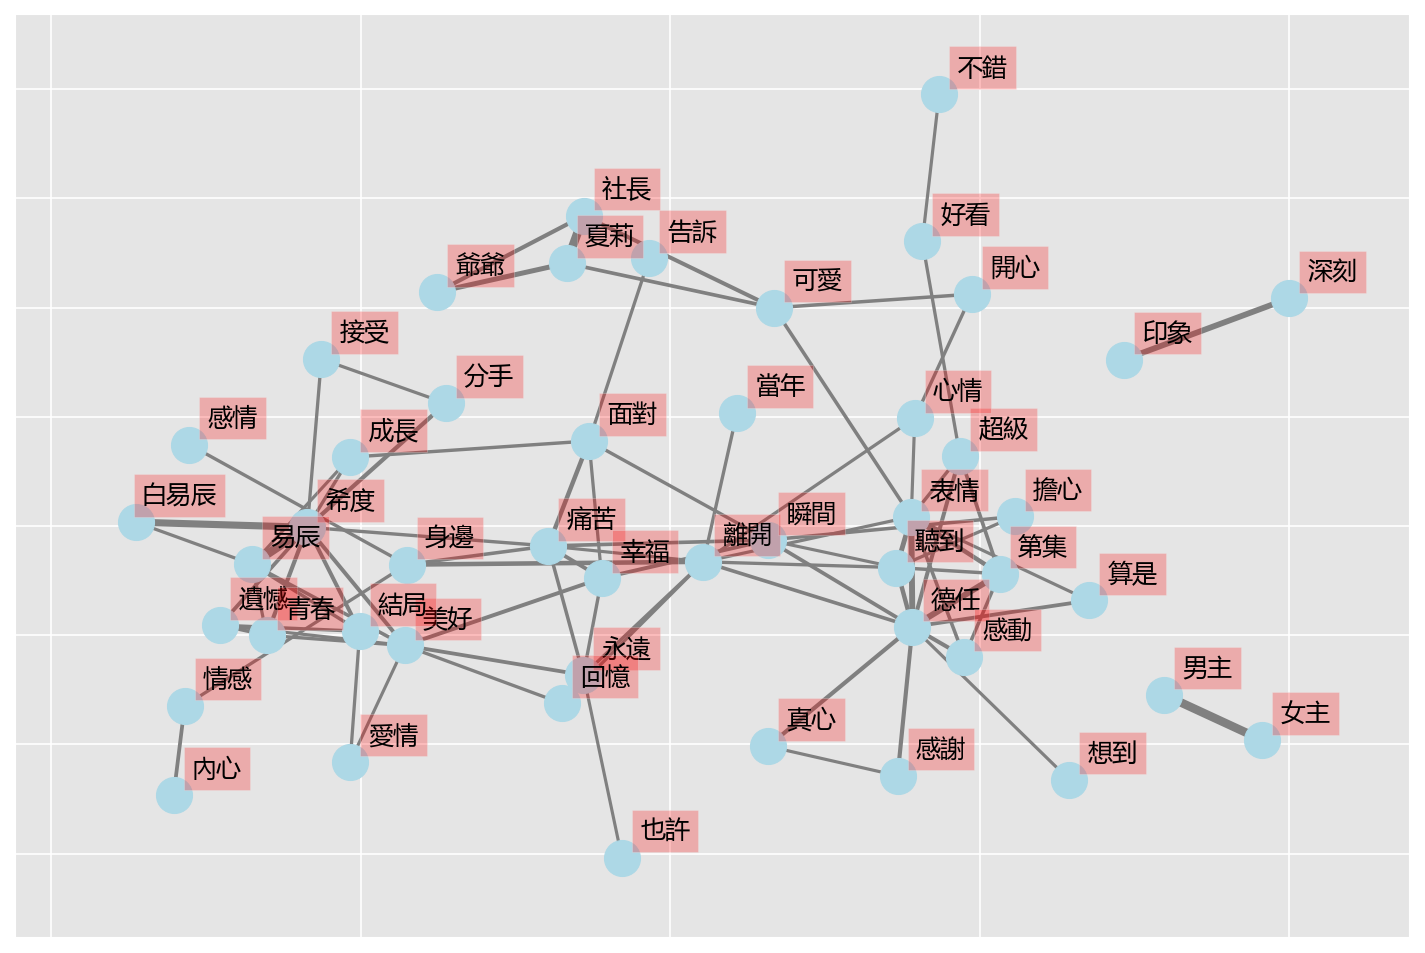

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.3)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

上圖可以分成幾群:<br>
  + 社內相親(圖上方)
    + 劇中的女主角「申夏莉」、「社長(男主角)」以及「(男主角的)爺爺」常常被網友們一起討論(該劇劇情也確實圍繞著這三個角色展開)
  + 二十五。二十一(圖的左方): 
    + 這部韓劇為討論度較熱烈的韓劇，主要聚焦於「希度(女主角)」、「白易辰(男主角)」，也可以發現觀眾多聚焦於探討兩人之間的情感關係。
    + 此外，可以發現在結局方面也有較多的討論。
  + 與劇情相關詞彙(中右方)
    + 如「痛苦」、「幸福」、「回憶」等
  + 與觀看評價相關(右上方)
    + 如「印象深刻」、「好看」、「不錯」等

## LDA模型

在本節，我們以無監督學習的方式分類韓劇版版友討論的內容，以觀察主要討論的議題類型。

#### 處理文章

In [ ]:
docs = lda_df['words'].to_list()
docs[0]

['柔美',
 '細胞',
 '小將',
 '原聲帶',
 '配樂',
 '合輯',
 '音源',
 '將於日',
 '下午',
 '音源',
 '網站',
 '陸續',
 '發布',
 '包括',
 '發布',
 '原聲帶',
 '歌曲',
 '配樂',
 '共計',
 '曲目',
 '伴隨',
 '柔美',
 '麻辣燙',
 '年糕',
 '伴奏',
 '細胞',
 '樂隊',
 '有望',
 '給觀眾',
 '留下',
 '深刻印象',
 '一首',
 '柔美',
 '細胞',
 '小將',
 '原聲帶',
 '一首歌',
 '旋律',
 '洗腦',
 '一首',
 '具雄',
 '柔美',
 '噴水池',
 '一見鍾情',
 '片尾曲',
 '歌曲',
 '悲傷',
 '歌曲',
 '偵探',
 '細胞',
 '專屬',
 '愛情',
 '細胞',
 '專屬',
 '時尚',
 '細胞',
 '專屬',
 '細胞',
 '專屬',
 '不安',
 '細胞',
 '專屬',
 '嘿咻',
 '細胞',
 '專屬',
 '柔美',
 '守衛',
 '專屬',
 '搞笑',
 '細胞',
 '專屬',
 '嘴饞',
 '細胞',
 '專屬',
 '一號',
 '專屬',
 '賽理',
 '疑心',
 '花粉',
 '有雷',
 '柔美',
 '結局',
 '集具雄',
 '很傻',
 '時機',
 '思考',
 '過久還',
 '很常',
 '省略',
 '捍衛',
 '自尊心',
 '柔美',
 '心累',
 '雄才',
 '意識',
 '危機',
 '柔美',
 '心中',
 '地位',
 '柔美',
 '捨得',
 '具雄',
 '暫住',
 '同居',
 '相處',
 '模式',
 '柔美',
 '小雄',
 '狀況',
 '不太好',
 '不在乎',
 '小雄',
 '提出',
 '打算',
 '而小雄',
 '自信',
 '害怕',
 '擔心',
 '錯過',
 '回覆',
 '時機',
 '重點',
 '加深',
 '柔美',
 '誤解',
 '具雄',
 '每次',
 '時刻',
 '演算法',
 '最爛',
 '搬出去',
 '招有',
 '難關',
 '逃避',
 '具雄',
 '適合',
 '柔美',
 '回憶',
 '具雄',
 '點點滴滴

In [ ]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-06-08 15:01:17,596 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-06-08 15:01:17,893 : INFO : built Dictionary<58247 unique tokens: ['一季', '一號', '一見鍾情', '一首', '一首歌']...> from 2036 documents (total 378208 corpus positions)
2024-06-08 15:01:17,894 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<58247 unique tokens: ['一季', '一號', '一見鍾情', '一首', '一首歌']...> from 2036 documents (total 378208 corpus positions)", 'datetime': '2024-06-08T15:01:17.894293', 'gensim': '4.3.2', 'python': '3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}
2024-06-08 15:01:17,937 : INFO : discarding 47601 tokens: [('不放過', 1), ('佈告', 2), ('你給', 4), ('修行', 2), ('共計', 2), ('冰雪', 1), ('合輯', 2), ('吝嗇鬼', 2), ('嘴饞', 2), ('嘿咻', 4)]...
2024-06-08 15:01:17,937 : INFO : keeping 10646 tokens which were in no less than 5 and no more than 2015 (=99.0%) documents
2024-06-08 15:01:17,962 : INFO : resultin

Dictionary<10646 unique tokens: ['一季', '一號', '一見鍾情', '一首', '一首歌']...>


In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一季: 0
一號: 1
一見鍾情: 2
一首: 3
一首歌: 4
下午: 5
不在: 6
不在乎: 7
不太好: 8
不安: 9
人選: 10
伴奏: 11


In [ ]:
pprint(" ".join(lda_df['words'].iloc[600]))

('年許 秦豪 處女作 八月 照相館 上映 女主角 沈銀河 本片 豪取 當年 青龍 獎及 百想 藝術 大賞 影后 南韓 三大 電影 獎已 可惜 獨缺 一座 '
 '大鐘 大鐘 贊助 單位 三星集團 亞洲 金融風暴 重創 瀕臨 倒閉 致該 年度 大鐘 延期 舉辦 沈銀河 極高 機率 將成 南韓 影史 第位 包辦 同年 '
 '三大 電影 大滿貫 影后 首位 老牌 影后 沈惠珍 沈銀河 何許人也 年歲 閃耀 出道 年後首 登大 銀幕 年內 囊括 三大 電影 影后 入袋 愛情 '
 '照鏡 大鐘 最佳 女主角 年代 大滿貫 影后 單論 得獎 資歷 同輩 全度妍 金惠秀 資深 螢幕上 留下 華麗 身影 閃電 嫁人 息影 迄今 復出 南韓 '
 '影壇 璀璨 一顆 流星 八月 照相館 輕巧 沈重 罹病 照相館 老闆 正元韓 石圭 生命 幾個 遇見 常來 沖洗 違規 停車 照片 年輕 交警 德琳 '
 '沈銀河 青春 正茂 躁動 不羈 德琳 問正元 開心 正元 回以 一貫 淡淡 微笑 微笑 自知 人世 正元 朋友家 紛紛 告別 回應德琳 一寸 芳心 '
 '臨終前 一封 寄出 不讓 德琳 得知 病情 默默 離開 正元 溫柔 德琳 照相館 見到 只見 館裡 掛著 一張 正元 拍攝 照片 淡淡地 建築學 概論 '
 '上映 黑馬 之姿 創下 觀影 人次 南韓 史上 票房 純愛 電影 朴寶英 少年 萬人次 男女 嚴泰成 此君 不熟 只知 嚴正 胞弟 韓佳人 早婚 美人 '
 '清純 相與 孫藝真 早年 三分 神似 李帝勳 裴秀智則 大學 時期 柳演 壞壞 大學 學長 柳演 參演 少年 奸角 連續 兩部 票房 大發 可靠 國民 '
 '壞蛋 男主角 童年 好友 則是 縱橫 劇場 本片 銀幕 擔任 配角 卻是 全片 最強 曹政 電影票房 長紅 助威 新晉 組合 廣受 好評 裴秀智 拿下 '
 '百想 最佳 新人 當年 對手 包含 金惠恩 方言 劍豪 梁燦美 教練 躍升 新一代 國民 初戀 初戀 初代 國民 初戀 孫藝真 意見 建築學 概論 現實 '
 '穿插 回憶 同步 敘事 手法 描述 同修 一堂 通識 大學生 勝民瑞英 相見 日久生情 未能 互訴 情衷 錯過 多年 再見 相遇 揭露 深藏 已久 心意 '
 '多年 回頭 望去 當年 情人 錯過 原因 略顯 孱弱 蒼白 男孩 多半 自信

In [ ]:
dictionary.doc2bow(lda_df['words'].iloc[600])[:10]

[(31, 2),
 (38, 2),
 (40, 1),
 (57, 1),
 (61, 2),
 (64, 3),
 (68, 1),
 (87, 1),
 (106, 1),
 (112, 2)]

In [ ]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
type(corpus)

list

#### 透過指標找出最佳主題數

選擇主題數 2~8 來做分析，建立不同主題述的模型後使用"perplexity"與"PMI"指標進行分析0以選出最佳分群數。

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 8)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 168.31354236602783 sec

2024-06-08 15:01:30,216 : INFO : using symmetric alpha at 0.5
2024-06-08 15:01:30,217 : INFO : using symmetric eta at 0.5
2024-06-08 15:01:30,220 : INFO : using serial LDA version on this node
2024-06-08 15:01:30,228 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 2036 documents, updating model once every 2000 documents, evaluating perplexity every 2036 documents, iterating 50x with a convergence threshold of 0.001000
2024-06-08 15:01:30,229 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-06-08 15:01:30,231 : INFO : PROGRESS: pass 0, at document #2000/2036
2024-06-08 15:01:30,869 : INFO : merging changes from 2000 documents into a model of 2036 documents
2024-06-08 15:01:30,879 : INFO : topic #0 (0.500): 0.007*"希度" + 0.003*"結局" + 0.003*"演技" + 0.003*"愛情" + 0.003*"理解" + 0.003*"畫面" + 0.002*"白易辰" + 0.002*"好看" + 0.002*"幸福" + 0.002*"感情"
2024-06-08 15:01:

花費時間: 112.23140740394592 sec


將不同topic_num時之 perplexity 與 pmi分別進行觀察。

In [ ]:
result = pd.DataFrame(result)
result

topic_num   perplexity       pmi
0          2  7520.706399 -0.041778
1          3  6347.401533 -0.057362
2          4  6070.658079 -0.037544
3          5  6100.739326 -0.064067
4          6  6058.779064 -0.070610
5          7  6133.959313 -0.082181

perplexity	在topic_num為4時表現最佳，其次是在topic_num為5時最佳； pmi 在topic_num為4時表現最佳，其次是在topic_num為2時最佳，故選擇topic_num = 4。

##### Perplexity 隨主題數變化圖

<Axes: xlabel='topic_num'>

2024-06-08 15:04:25,543 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-06-08 15:04:25,596 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-06-08 15:04:25,597 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-06-08 15:04:25,598 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-06-08 15:04:25,599 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-06-08 15:04:25,602 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-06-08 15:04:25,604 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

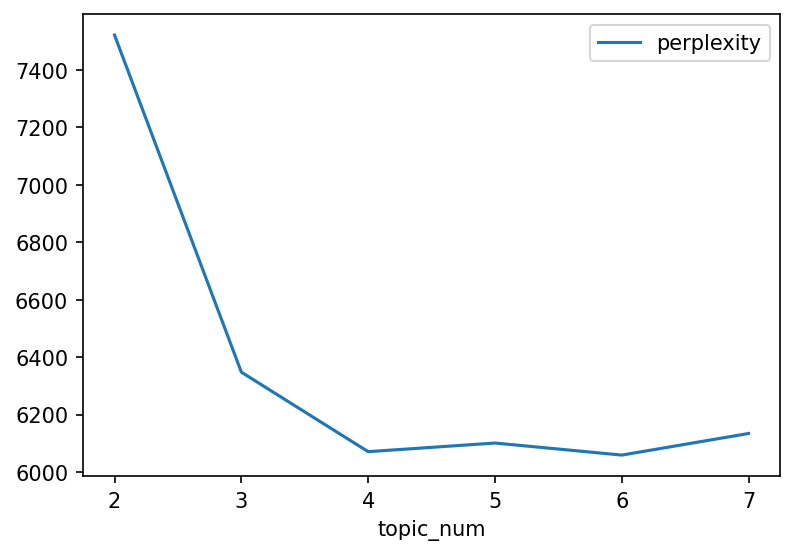

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

##### PMI隨主題數變化圖

<Axes: xlabel='topic_num'>

2024-06-08 15:04:26,645 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-06-08 15:04:26,646 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-06-08 15:04:26,646 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-06-08 15:04:26,648 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-06-08 15:04:26,649 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-06-08 15:04:26,650 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-06-08 15:04:26,651 : WARNING : findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
2024-0

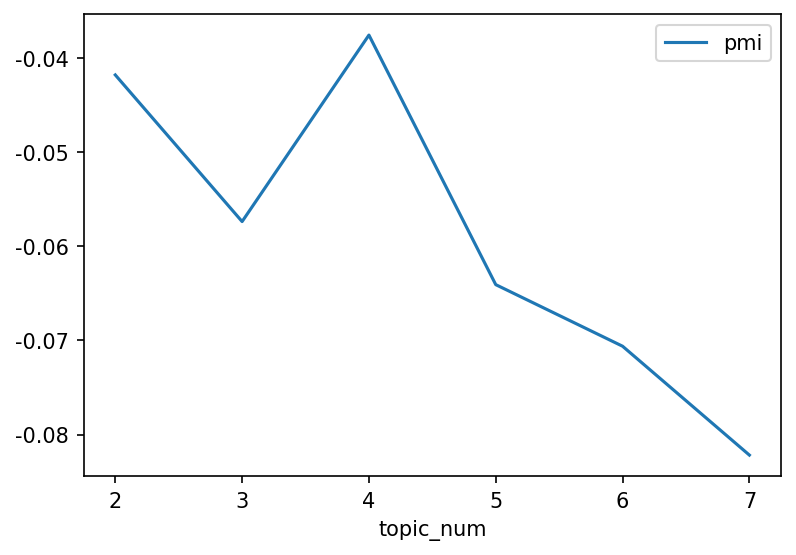

In [ ]:
result.plot.line(x='topic_num', y='pmi')

### 視覺化呈現

#### 分群一：主題數為4

In [ ]:
model_1 = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 10 # 訓練次數
    )

2024-06-08 15:04:43,433 : INFO : using symmetric alpha at 0.25
2024-06-08 15:04:43,433 : INFO : using symmetric eta at 0.25
2024-06-08 15:04:43,435 : INFO : using serial LDA version on this node
2024-06-08 15:04:43,440 : INFO : running online (multi-pass) LDA training, 4 topics, 10 passes over the supplied corpus of 2036 documents, updating model once every 2000 documents, evaluating perplexity every 2036 documents, iterating 50x with a convergence threshold of 0.001000
2024-06-08 15:04:43,442 : INFO : PROGRESS: pass 0, at document #2000/2036
2024-06-08 15:04:44,132 : INFO : merging changes from 2000 documents into a model of 2036 documents
2024-06-08 15:04:44,135 : INFO : topic #0 (0.250): 0.008*"希度" + 0.004*"結局" + 0.003*"演技" + 0.003*"畫面" + 0.003*"好看" + 0.002*"愛情" + 0.002*"理解" + 0.002*"女主角" + 0.002*"幸福" + 0.002*"白易辰"
2024-06-08 15:04:44,135 : INFO : topic #1 (0.250): 0.005*"德任" + 0.003*"期待" + 0.003*"可愛" + 0.003*"愛情" + 0.003*"結局" + 0.003*"希度" + 0.002*"感情" + 0.002*"演技" + 0.002*"男主角" + 0

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_1, corpus, dictionary)
p

c:\Users\lian\Desktop\社媒個人作業\範例\EnvName01\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.012501 -0.104071       1        1  90.878905
1     -0.221687  0.015433       2        1   3.303795
2      0.141130 -0.127480       3        1   3.191339
0      0.093058  0.216118       4        1   2.625961, topic_info=      Term         Freq        Total Category  logprob  loglift
10624   海仁  1013.000000  1013.000000  Default  30.0000  30.0000
122     結局   834.000000   834.000000  Default  29.0000  29.0000
600     演技   749.000000   749.000000  Default  28.0000  28.0000
432     期待   699.000000   699.000000  Default  27.0000  27.0000
32      可愛   731.000000   731.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
783    第一次    26.532494   436.871360   Topic4  -5.6825   0.8385
432     期待    26.579962   699.997500   Topic4  -5.6807   0.3688
32      可愛    26.438045   731.460877   Topic4  -5.6861   0.3195
374     完美    23.446528   228.022050   Topic4  -5.8061   1.3650
545     幸福    23.237823   558.991916   Topic4  -5.8151   0.4594

[320 rows x 6 columns], token_table=       Topic      Freq Term
term                       
164        1  0.807934   不想
164        2  0.068276   不想
164        3  0.072828   不想
164        4  0.052345   不想
400        1  0.918579   不錯
...      ...       ...  ...
10220      2  0.812034   點醒
10626      1  0.031910   龍頭
10626      2  0.127639   龍頭
10626      3  0.255277   龍頭
10626      4  0.606283   龍頭

[657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

+ 觀察結果
    + 主題一<br>
可觀察到三個名字「希度」、「德任」、「白易辰」，其中「希度」與「易辰」是2022年《二十五，二十一》連續劇中女主角與男主角的名字，「德任」則是2021年底開播連續劇《衣袖紅鑲邊》中女主角的名字。《二十五，二十一》的劇情主要描述現代兩位年輕男女的愛情故事，《衣袖紅鑲邊》則是講述正祖李祘和宜嬪成德任的歷史愛情故事，從Top-30 Most Relevant Terms可以了解到主題一是根據「愛情」這個關鍵字將這兩部劇分為同一群，並且這兩部劇皆為悲劇結尾，因此結局也十分有討論度。整體而言，主題一主要為討論兩部愛情連續劇結局的文章。<br>

    + 主題二、主題三、主題四<br>
    主題二、主題三與主題四皆有提到韓劇《淚之女王》女主角的名字「海仁」，但討論重點不同，以下分述。<br><br>主題二中透過Most Relevant Terms「小率」、「善宰」、「海仁」可知討論的內容以《背著善宰跑》與《淚之女王》兩部韓劇為主，《背著善宰跑》為2024年上映的韓國連續劇，然而根據分類中排序較前的關鍵字「穿越」與「記憶」可知本主題討論的內容與穿越劇《背著善宰跑》較相關，《淚之女王》相關的內容可能是因為同樣有「記憶」、「反派」等關鍵字且跟《背著善宰跑》檔期前後相連因此一起被討論。<br><br>主題三的文章內容主要為2024年上映韓劇《淚之女王》，「金秀賢」與「金智媛」為該劇主演，「海仁」、「賢佑」、「尹殷盛」分別為劇中女主角、男主角與男配角的名字。由「離婚」、「記憶」、「忘記」、「尹殷盛」可以推知主題三主要在討論《淚之女王》中女主角失憶並與男配角互動的橋段。<br><br>主題四中，透過「結局」、「失憶」、「記憶」、「車禍」可以推知主題四的文章主要在討論女主角經歷車禍手術開刀失憶的劇情，以及緊接其後女主角在恢復記憶並幸福的結局。


**小結**<br>
透過LDA的四個主題分類可以發現2022年至2024年PTT韓劇版擁有過較高討論度的話題主要是近期熱播韓劇《淚之女王》的重要情節，以及2022年的兩部韓劇《二十五，二十一》與《衣袖紅鑲邊》。此外，「結局」一詞在四個分類中皆有出現，且於主題一集主題四中相關性高，反映出連續劇結局為能讓韓劇版版友熱烈討論的議題。

#### 分群二：主題數為5

有鑑於前次分群後各群數量不平均且討論的劇較集中，因此根據perplexity與pmi選擇次好的群數(5)嘗試分群。

In [ ]:
model_4_2 = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 968,
    passes = 30 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_4_2, corpus, dictionary)
p

2024-06-09 02:48:48,313 : INFO : using symmetric alpha at 0.2
2024-06-09 02:48:48,315 : INFO : using symmetric eta at 0.2
2024-06-09 02:48:48,316 : INFO : using serial LDA version on this node
2024-06-09 02:48:48,322 : INFO : running online (multi-pass) LDA training, 5 topics, 30 passes over the supplied corpus of 2036 documents, updating model once every 2000 documents, evaluating perplexity every 2036 documents, iterating 50x with a convergence threshold of 0.001000
2024-06-09 02:48:48,323 : INFO : PROGRESS: pass 0, at document #2000/2036
2024-06-09 02:48:49,095 : INFO : merging changes from 2000 documents into a model of 2036 documents
2024-06-09 02:48:49,098 : INFO : topic #0 (0.200): 0.007*"希度" + 0.004*"結局" + 0.004*"愛情" + 0.003*"德任" + 0.003*"感情" + 0.003*"易辰" + 0.002*"可愛" + 0.002*"理解" + 0.002*"關係" + 0.002*"女主"
2024-06-09 02:48:49,099 : INFO : topic #1 (0.200): 0.004*"愛情" + 0.003*"德任" + 0.003*"可愛" + 0.003*"期待" + 0.003*"女主角" + 0.003*"希度" + 0.002*"關係" + 0.002*"男主角" + 0.002*"理解" + 0.00

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.024638 -0.039950       1        1  80.079983
2     -0.272024 -0.160014       2        1  11.079264
1      0.131127 -0.001926       3        1   4.543095
3     -0.085925  0.288467       4        1   2.359916
0      0.202185 -0.086577       5        1   1.937741, topic_info=      Term        Freq       Total Category  logprob  loglift
10624   海仁  925.000000  925.000000  Default  30.0000  30.0000
122     結局  942.000000  942.000000  Default  29.0000  29.0000
600     演技  642.000000  642.000000  Default  28.0000  28.0000
3725    德任  523.000000  523.000000  Default  27.0000  27.0000
64      愛情  878.000000  878.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
461     過程   19.150370  415.765739   Topic5  -5.7046   0.8658
496     關係   19.297935  593.604112   Topic5  -5.6969   0.5174
545     幸福   19.219374  618.049119   Topic5  -5.7010   0.4730
122     結局   19.178348  942.368651   Topic5  -5.7032   0.0490
2303    小孩   15.846649  266.107478   Topic5  -5.8940   1.1227

[384 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
161        1  0.975190    一句
161        3  0.021200    一句
3760       5  0.931970  一如既往
5614       1  0.127616    一絲
5614       2  0.865968    一絲
...      ...       ...   ...
307        2  0.004506    面前
307        3  0.013518    面前
8518       4  0.881981    高麗
7128       3  0.948516   麥克風
10399      4  0.969437    黑幫

[675 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 4, 1])

主題數為五的分群結果更傾向於根據不同的劇進行分類，主題一討論內容以《二十五二十一》為主，然而混雜了部分《淚之女王》的關鍵字且內容較廣泛；主題三、四討論主題皆為《淚之女王》，主題三著重在男配角戲份較重的部分，主題四則與結局討論較相關；主題二討論主題為《衣袖紅鑲邊》，相關字詞包含「德任」、「世子」、「中殿」、「古裝」、「宮女」等；主題五則是討論《背著善宰跑》，相關字詞包含「小率」、「善宰」、「穿越」、「奇幻」等。<br><br>
**小結**
在主題數為五時可發現《淚之女王》、《二十五二十一》、《衣袖紅鑲邊》與《背著善宰跑》仍是熱門討論的話題。

## 社群網路分析


從主題模型看出PTT用戶對韓劇的討論方向後, 接下來我們決定著重在使用者分析上, 研究韓劇版的社群

In [ ]:
! pip install pandas
! pip install numpy
! pip install pyvis
! pip install networkx
! pip install IPython

In [ ]:
import pandas as pd
import numpy as np
import pyvis
import networkx as nx
from IPython.display import Image

In [ ]:
raw_data = pd.read_csv('k_newdata.csv')
raw_data = raw_data[raw_data.artComment != '[]']
raw_data = raw_data.sample(round(raw_data.shape[0]/4), random_state=2024)
print(raw_data.shape)
raw_data.head()

(501, 11)


system_id                                             artUrl  \
953         954  https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...   
1811       1812  https://www.ptt.cc/bbs/KoreaDrama/M.1705079319...   
1688       1689  https://www.ptt.cc/bbs/KoreaDrama/M.1698556382...   
1882       1883  https://www.ptt.cc/bbs/KoreaDrama/M.1708749619...   
1420       1421  https://www.ptt.cc/bbs/KoreaDrama/M.1680616892...   

                   artTitle              artDate   artPoster artCatagory  \
953             [心得]非常律師禹英禑  2022-08-05 17:26:12     meechia  KoreaDrama   
1811              [問題]異能的劇情  2024-01-13 01:08:37    ckshchen  KoreaDrama   
1688        [心得]室友李斗娜與人魚艾莉兒  2023-10-29 13:12:59     kairiyu  KoreaDrama   
1882  [心得]韓劇幼幼班喜歡《少年法庭》《信號》  2024-02-24 12:40:15       Lynyu  KoreaDrama   
1420  [心得]離婚律師申晟瀚EP09~10(雷)  2023-04-04 22:01:30  singerjoan  KoreaDrama   

                                             artContent  \
953   經朋友推薦，一看之下驚為天人，應該是最近最好看的韓劇了吧？\n爬文看到之前好多討論我應該是撥...   
1811  1.九龍浦到底有沒有言靈能力?\n\n開頭叫炸雞的黑道本來很不客氣\n他一開口就忽然很聽話，...   
1688  這齣戲細節太多，斗娜太正，畫面太美，歌太好聽，\n\n忍不住快速二刷後，\n\n發現一點小小...   
1882  大家好，本板首PO，有看過板規，知道心得文要發200字以上\n如果還是不小心觸犯了什麼還請盡...   
1420  簡單帶過外配跟海南大叔的離婚案件\n(反正也是強行大團圓結局)\n總而言之言而總之，靠著血型...   

                                             artComment             e_ip  \
953   [{"cmtStatus": "推", "cmtPoster": "gyaoqwas", "...    219.85.179.62   
1811  [{"cmtStatus": "推", "cmtPoster": "caca13140405...  118.161.208.199   
1688  [{"cmtStatus": "推", "cmtPoster": "Inborn", "cm...    182.233.99.81   
1882  [{"cmtStatus": "推", "cmtPoster": "shumei", "cm...     36.232.50.27   
1420  [{"cmtStatus": "推", "cmtPoster": "raininglight...     101.9.32.158   

             insertedDate dataSource  
953   2022-08-06 02:17:56        ptt  
1811  2024-01-13 02:13:16        ptt  
1688  2023-10-30 01:49:26        ptt  
1882  2024-02-25 01:50:27        ptt  
1420  2023-04-05 01:48:04        ptt

取得留言者跟狀態（推）

In [ ]:
#parse comment

def getComtInfo(com):
  cmters,cmt_statuss = [],[]
  com = eval(com)
  for i in com:
    print(i)
    cmters.append(i['cmtPoster'])
    cmt_statuss.append(i['cmtStatus'])
  return pd.Series([cmters, cmt_statuss])

raw_data[['artComter','artStatus']] = raw_data['artComment'].apply(lambda r: getComtInfo(r))

{'cmtStatus': '推', 'cmtPoster': 'gyaoqwas', 'cmtContent': ':爸爸那個是用高級壽司盒裝的紫菜飯捲捏', 'cmtDate': '2022-08-05 17:29:00'}
{'cmtStatus': '→', 'cmtPoster': 'Howard61313', 'cmtContent': ':緊處理的春日暖陽XD', 'cmtDate': '2022-08-05 17:53:00'}
{'cmtStatus': '推', 'cmtPoster': 'cloudlife', 'cmtContent': ':祝春日暖陽和鯨魚修成正果，誤，快逃', 'cmtDate': '2022-08-05 18:45:00'}
{'cmtStatus': '推', 'cmtPoster': 'maxcat11', 'cmtContent': ':樓上c大，不要這樣，叫還不是男友的國民失落男濬浩該怎', 'cmtDate': '2022-08-05 19:12:00'}
{'cmtStatus': '→', 'cmtPoster': 'maxcat11', 'cmtContent': ':麼辦啦，搜搜配', 'cmtDate': '2022-08-05 19:12:00'}
{'cmtStatus': '推', 'cmtPoster': 'matida24', 'cmtContent': ':男主開車太帥，充滿男友力', 'cmtDate': '2022-08-05 19:18:00'}
{'cmtStatus': '推', 'cmtPoster': 'MOMOXOXO', 'cmtContent': ':看到黑白切笑出來那個應該是類似台灣的男生女生配吧？', 'cmtDate': '2022-08-05 20:30:00'}
{'cmtStatus': '推', 'cmtPoster': 'awheaton311', 'cmtContent': ':有第一點喔看來我需要重看了', 'cmtDate': '2022-08-05 20:32:00'}
{'cmtStatus': '推', 'cmtPoster': 'chew0412', 'cmtContent': ':超喜歡第2點男主角眼神閃爍的摸樣，心好癢啊～', 'cmt

In [ ]:
raw_data = raw_data.explode(['artComter','artStatus'])
social_data = raw_data[['artUrl','artPoster','artComter','artStatus']]
social_data.head(10)

artUrl artPoster    artComter  \
953  https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...   meechia     gyaoqwas   
953  https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...   meechia  Howard61313   
953  https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...   meechia    cloudlife   
953  https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...   meechia     maxcat11   
953  https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...   meechia     maxcat11   
953  https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...   meechia     matida24   
953  https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...   meechia     MOMOXOXO   
953  https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...   meechia  awheaton311   
953  https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...   meechia     chew0412   
953  https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...   meechia      ChrisAJ   

    artStatus  
953         推  
953         →  
953         推  
953         推  
953         →  
953         推  
953         推  
953         推  
953         推  
953         推

In [ ]:
social_data

artUrl   artPoster  \
953   https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...     meechia   
953   https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...     meechia   
953   https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...     meechia   
953   https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...     meechia   
953   https://www.ptt.cc/bbs/KoreaDrama/M.1659691574...     meechia   
...                                                 ...         ...   
1256  https://www.ptt.cc/bbs/KoreaDrama/M.1673460181...  cherryiami   
1256  https://www.ptt.cc/bbs/KoreaDrama/M.1673460181...  cherryiami   
1256  https://www.ptt.cc/bbs/KoreaDrama/M.1673460181...  cherryiami   
1256  https://www.ptt.cc/bbs/KoreaDrama/M.1673460181...  cherryiami   
1256  https://www.ptt.cc/bbs/KoreaDrama/M.1673460181...  cherryiami   

        artComter artStatus  
953      gyaoqwas         推  
953   Howard61313         →  
953     cloudlife         推  
953      maxcat11         推  
953      maxcat11         →  
...           ...       ...  
1256   wind831147         推  
1256   wind831147         →  
1256   wind831147         →  
1256   wind831147         →  
1256      essendo         推  

[30280 rows x 4 columns]

就算我們已經sample 1/4的資料, 每個貼文下還是有很多留言, 可見大家對於韓劇討論是蠻踴躍的。</br>
所以我們決定只分析討論度前10的貼文

In [ ]:
# count how many comments under each article
social_data['artUrl'].value_counts()

# select top 10 articles with most comments
social_data = social_data[social_data['artUrl'].isin(social_data['artUrl'].value_counts().head(10).index)]
social_data.head()

artUrl  artPoster  \
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   

         artComter artStatus  
1043  theskyofblue         推  
1043  theskyofblue         →  
1043        d61131         推  
1043        d61131         →  
1043        d61131         →

In [ ]:
social_data

artUrl  artPoster  \
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
...                                                 ...        ...   
95    https://www.ptt.cc/bbs/KoreaDrama/M.1639585105...  balagodie   
95    https://www.ptt.cc/bbs/KoreaDrama/M.1639585105...  balagodie   
95    https://www.ptt.cc/bbs/KoreaDrama/M.1639585105...  balagodie   
95    https://www.ptt.cc/bbs/KoreaDrama/M.1639585105...  balagodie   
95    https://www.ptt.cc/bbs/KoreaDrama/M.1639585105...  balagodie   

         artComter artStatus  
1043  theskyofblue         推  
1043  theskyofblue         →  
1043        d61131         推  
1043        d61131         →  
1043        d61131         →  
...            ...       ...  
95        joliette         推  
95       seeseelee         推  
95      Sabine0127         推  
95       watase124         →  
95      NickeyOrli         推  

[3612 rows x 4 columns]

In [ ]:
# 建立邊的資料
import random


po_df = social_data[['artPoster','artUrl']].drop_duplicates().rename(columns = {'artPoster':'src','artUrl':'dis'})
sample_url = random.choices(po_df.dis.unique().tolist(),k=300)
po_df = po_df[po_df.dis.isin(sample_url)]
re_df = social_data[['artComter','artUrl','artStatus']].rename(columns = {'artComter':'src','artUrl':'dis','artStatus':'weight'})
re_df = re_df[re_df.dis.isin(sample_url)]
re_df = re_df[~re_df['src'].isna()]



def convertStatus(s):
  if s == '推':
    return 2
  elif s == '→':
    return 1
  else :
    return -1
re_df['weight'] = re_df['weight'].map(convertStatus)
re_df = re_df.groupby(['src','dis']).sum().reset_index()

# 設定分數低的為紅色
def getColor(w):
  if w>0:
    return 'green'
  else:
    return 'red'
re_df['color'] = re_df.weight.map(getColor)
re_df

src                                                dis  weight  \
0     A00610lol  https://www.ptt.cc/bbs/KoreaDrama/M.1712415629...       2   
1           ACU  https://www.ptt.cc/bbs/KoreaDrama/M.1695341378...      -1   
2         AHAAA  https://www.ptt.cc/bbs/KoreaDrama/M.1695341378...       1   
3        ALIWOO  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...      15   
4       AP6WU06  https://www.ptt.cc/bbs/KoreaDrama/M.1695341378...       1   
...         ...                                                ...     ...   
1228   ziyun034  https://www.ptt.cc/bbs/KoreaDrama/M.1712415629...       2   
1229     zoo007  https://www.ptt.cc/bbs/KoreaDrama/M.1712415629...       3   
1230   zora9794  https://www.ptt.cc/bbs/KoreaDrama/M.1649510391...      10   
1231   zzchihzz  https://www.ptt.cc/bbs/KoreaDrama/M.1648615845...      11   
1232     zzzhan  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...       2   

      color  
0     green  
1       red  
2     green  
3     green  
4     green  
...     ...  
1228  green  
1229  green  
1230  green  
1231  green  
1232  green  

[1233 rows x 4 columns]

### 貼文與留言網路: 討論度前10貼文

In [ ]:
# 人為綠色節點
# po文為橘色節點

netWork = pyvis.network.Network(notebook=True, cdn_resources='in_line',directed=True)
person = list(set(po_df.src.unique().tolist()+re_df.src.unique().tolist()))
url = po_df.dis.unique().tolist()
netWork.add_nodes(
    nodes = person,
    value = [1 for i in range(len(person))],
    color = ['#66CDAA' for i in range(len(person))],
    title = person
)
netWork.add_nodes(
    nodes = url,
    value = [2 for i in range(len(url))],
    color = ['#FFB366' for i in range(len(url))],
    title = url
)
for i in po_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color='grey')
for i in re_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color=i[3])

# 設定layout
netWork.repulsion()

netWork.save_graph('network.html')

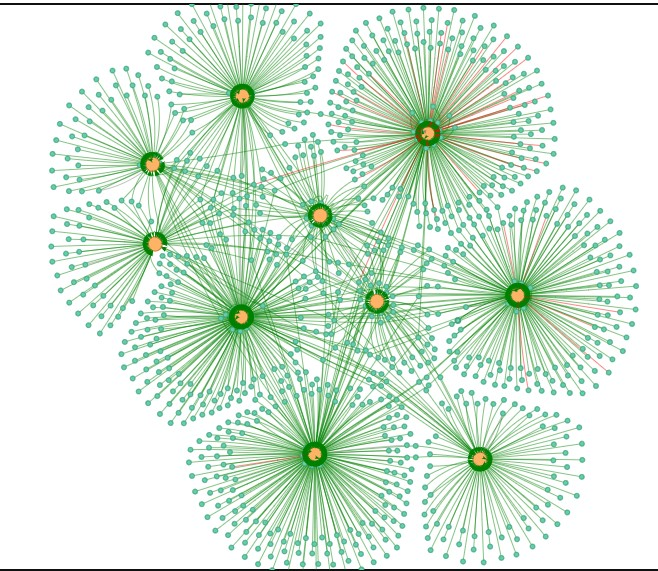

In [ ]:
# 用圖片呈現結果
Image(filename='network.jpg')

可以看到右上角有一個節點的評論很多, 而且其中含有很多紅線, 所以我們決定實際去PTT搜索該則貼文看看是什麼原因導致這樣的結果。

貼文:

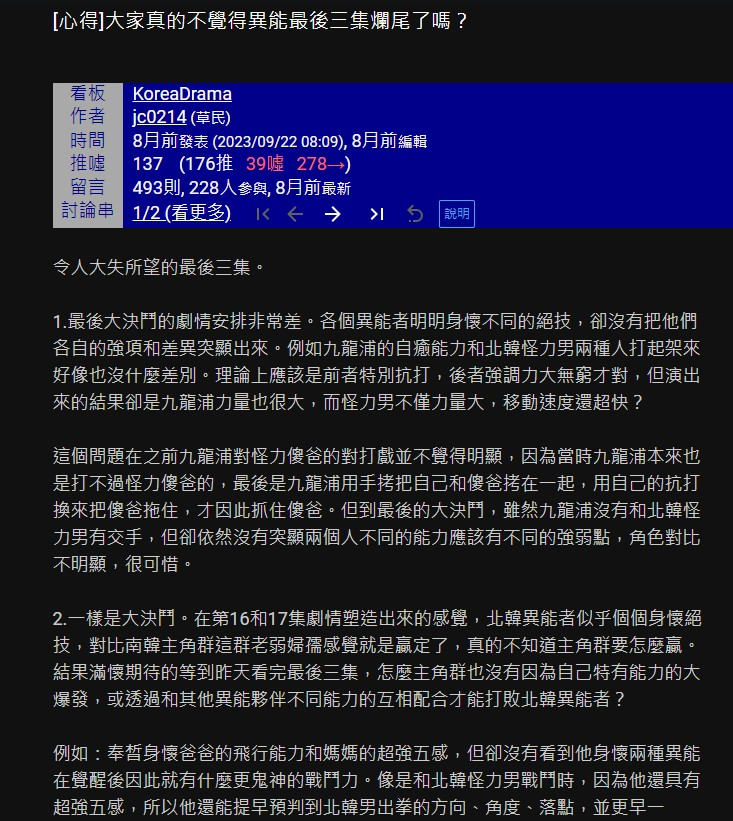

In [ ]:
# Show ptt
Image(filename='ptt1.jpg')

留言:

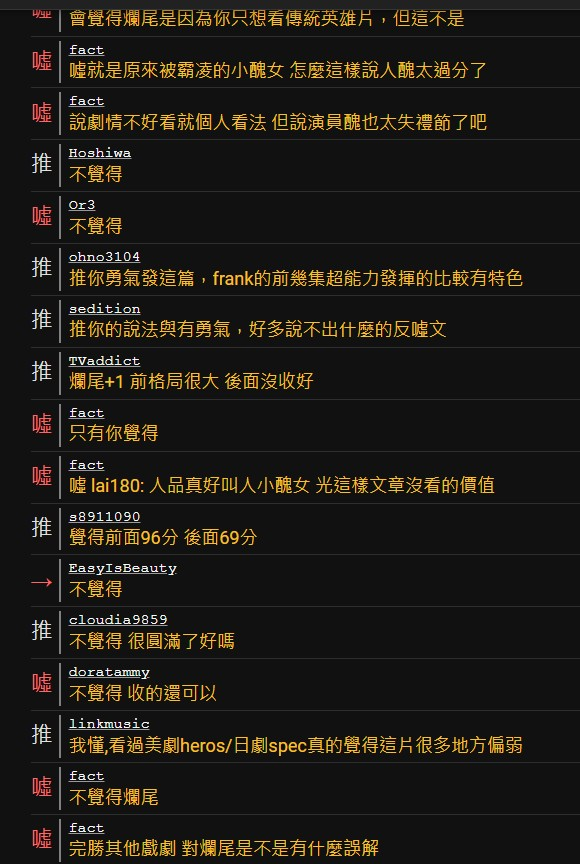

In [ ]:
Image(filename='ptt2.jpg')

發現:</br>
這則貼文是在討論知名韓劇「異能」相關劇情，而且大家對於劇情各有不同看法，因此討論度熱烈，正負評都有。此外，許多人認為該劇結局還可以接受，故不同意貼文者對於結局「爛尾」的看法，噓聲連連。

### 尋找網友之間的關係

In [ ]:
pos_cmt = social_data.copy()
pos_cmt = pos_cmt[~pos_cmt.artComter.isna()]
pos_cmt.head(10)

artUrl  artPoster  \
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   
1043  https://www.ptt.cc/bbs/KoreaDrama/M.1663443744...  rrraaayyy   

         artComter artStatus  
1043  theskyofblue         推  
1043  theskyofblue         →  
1043        d61131         推  
1043        d61131         →  
1043        d61131         →  
1043        hugr85         推  
1043   galaraga911         推  
1043   galaraga911         →  
1043   galaraga911         →  
1043   galaraga911         →

In [ ]:
pos_cmt['score'] = pos_cmt['artStatus'].apply(lambda r: convertStatus(r))
pos_cmt = pos_cmt.groupby(['artComter','artPoster']).sum('score').reset_index()
pos_cmt = pos_cmt[pos_cmt.score>=0]
pos_cmt = pos_cmt[pos_cmt.artComter != pos_cmt.artPoster]
# pos_cmt.score = 1
pos_cmt

artComter  artPoster  score
0     A00610lol     fantaa      2
2         AHAAA     jc0214      1
3        ALIWOO  rrraaayyy     15
4       AP6WU06     jc0214      1
5        Agneta     jc0214      1
...         ...        ...    ...
1215      zi777   zora9794      6
1216   ziyun034     fantaa      2
1217     zoo007     fantaa      3
1219   zzchihzz  yenwen869     11
1220     zzzhan  rrraaayyy      2

[1183 rows x 3 columns]

In [ ]:
pers = np.unique(pos_cmt[['artComter', 'artPoster']])
mat = pd.pivot_table(pos_cmt,index = 'artComter', columns = 'artPoster' ,values='score' ).fillna(0)\
  .reindex(columns=pers, index=pers, fill_value=0).to_numpy()
print(mat.shape)
tri = (np.tril(mat,-1).T + np.triu(mat,1))
mat_s = tri+tri.T

(1009, 1009)


In [ ]:
def random_color():
  r = lambda: random.randint(0,255)
  return '#%02X%02X%02X' % (r(),r(),r())

def matPresentGraph(mat:np.array,node_id:list,node_type:list=None,node_value:list = None,directed = True,edge_color=None) -> pyvis.network.Network:

  if directed != True:
    if (mat == mat.transpose()).all():
      print('matrix is Symmetric')
    else:
      print('matrix is not Symmetric')
  if node_type == None:
    c = random_color()
    node_colors = [c for i in range(len(node_id))]
    node_type = [" " for i in range(len(node_id))]
  else:
    node_color_map = {}
    for i in set(node_type):
      while True:
        c = random_color()
        if c not in node_color_map.values():
          break
      node_color_map[i] = c
    node_colors = [node_color_map[i] for i in node_type]
  # print(node_colors)
  if edge_color == None:
    edge_color = random_color()
  edge_color = random_color()
  if node_value == None:
    node_value = [1 for i in range(len(node_id))]

  net = pyvis.network.Network(notebook=True, directed = directed, cdn_resources='in_line')
  
  titles_list = []
  for i ,j in zip(node_id,node_type):
    titles_list.append(str(i)+":"+str(j))

  net.add_nodes(
      nodes = node_id,
      value = node_value,
      label = node_id,
      title = titles_list,
      color = node_colors
  )

  for row in range(len(node_id)):
    for col in range(len(node_id)):
      if mat[row][col]>0.:
        net.add_edge(
            node_id[row],node_id[col],width = mat[row][col],color = edge_color,title = mat[row][col]
        )
  net.repulsion()
  return net

設定網友的節點類型（同時為發文、留言者 / 發文者 / 留言者）

In [ ]:
# 定義發文者（po）、評論者(cmt)、兩者兼具(both)
node_type = []

cmt_list = pos_cmt['artComter'].unique().tolist()
po_list = pos_cmt['artPoster'].unique().tolist()
both_list = list(set(cmt_list) & set(po_list))
for p in pers:
  if p in both_list:
    node_type.append('both')

  elif p in cmt_list:
    node_type.append('cmt')

  elif p in po_list:
    node_type.append('po')

In [ ]:
net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type)

net.save_graph('pers_network.html')

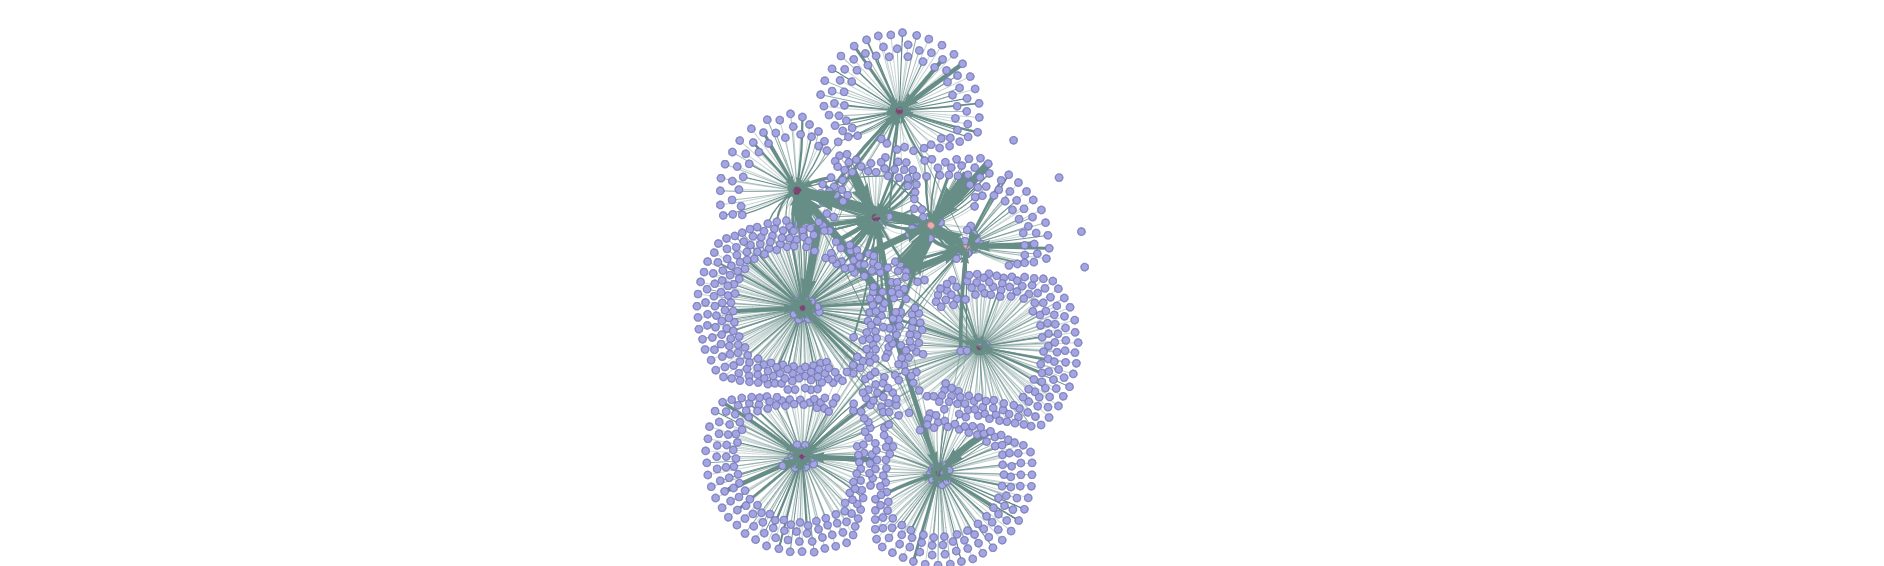

In [ ]:
## 呈現結果
Image(filename='pers_network.png')

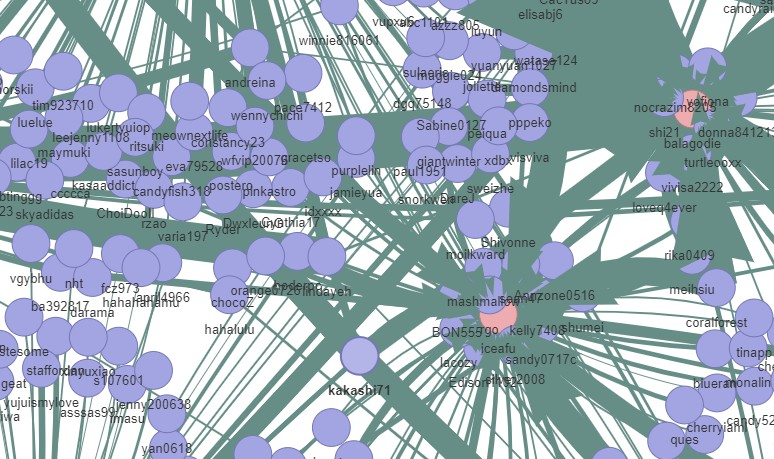

In [ ]:
Image(filename='most_weight.jpg')

可以看到裡面箭頭最粗的是這位叫做 kakashi 的網友(上圖的中下方), 且他對於右上和右下的討論度很高, 可能是這個版比較多意見的使用者</br>
接下來, 我們想看看在這幾篇文章中, 是否能找出連結社群的人, 這些人的特徵應該是betweeness 很高, 代表他們很常在各個文章下留言

In [ ]:
bet = np.array(list(nx.betweenness_centrality(nx.Graph(mat_s)).values()))
bet = (bet-np.min(bet))/(np.max(bet)-np.min(bet))
bet_q = np.quantile(bet,[.2,.4,.6,.8])

In [ ]:
node_value = []
for i in bet:
  if i > bet_q[3]:
    node_value.append(25)
  elif i > bet_q[2]:
    node_value.append(20)
  elif i>bet_q[1]:
    node_value.append(15)
  elif i>bet_q[0]:
    node_value.append(10)
  else:
    node_value.append(5)

net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type,node_value=node_value)
net.save_graph("./pers_bet_netWork.html")

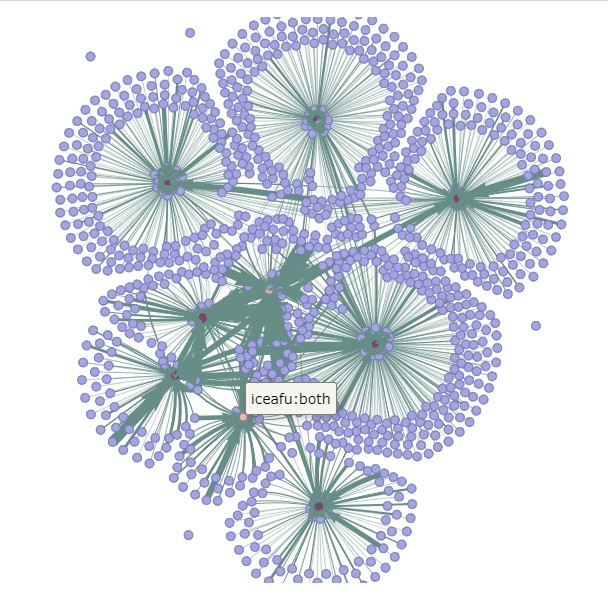

In [ ]:
Image(filename='bet_network.jpg')

可以從上圖看到，中間有兩個橘色的po文者同時也是評論者</br>
整體而言，在圖中也有多條較寬的edge，說明這個版別的人都滿積極討論的。</br>
接下來，我們來看看最大subgraph 圖的measure。

In [ ]:
# 計算max subgraph
G = nx.Graph(mat_s)
G_sub = sorted(nx.connected_components(G), key=len, reverse=True)
G_max_sub = G.subgraph(G_sub[0])
# # 重新定義 mat
sub_mat = nx.adjacency_matrix(G_max_sub).todense()
node_idx = list(G_max_sub.nodes)
sub_pers = pers[node_idx]

In [ ]:
net = matPresentGraph(mat=sub_mat,node_id=sub_pers,directed=False)
net.save_graph("./max_sub.html")

matrix is Symmetric


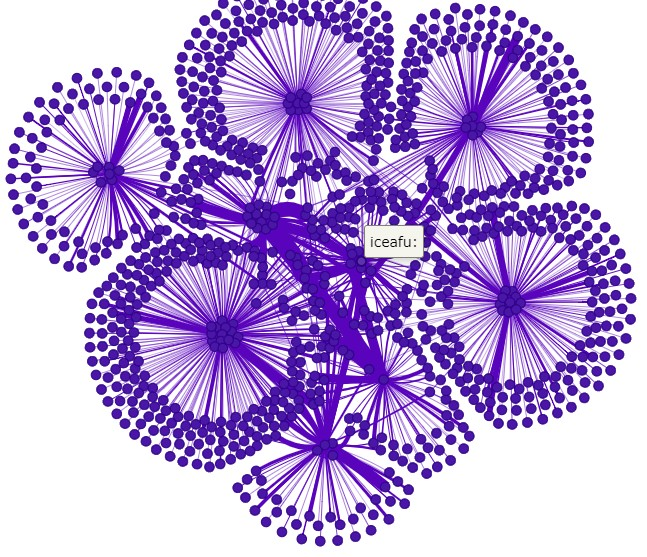

In [ ]:
Image(filename='max_sub.jpg')

接下來我們嘗試探索這位名為iceafu的用戶</br>
實際前往PTT搜尋其相關發文

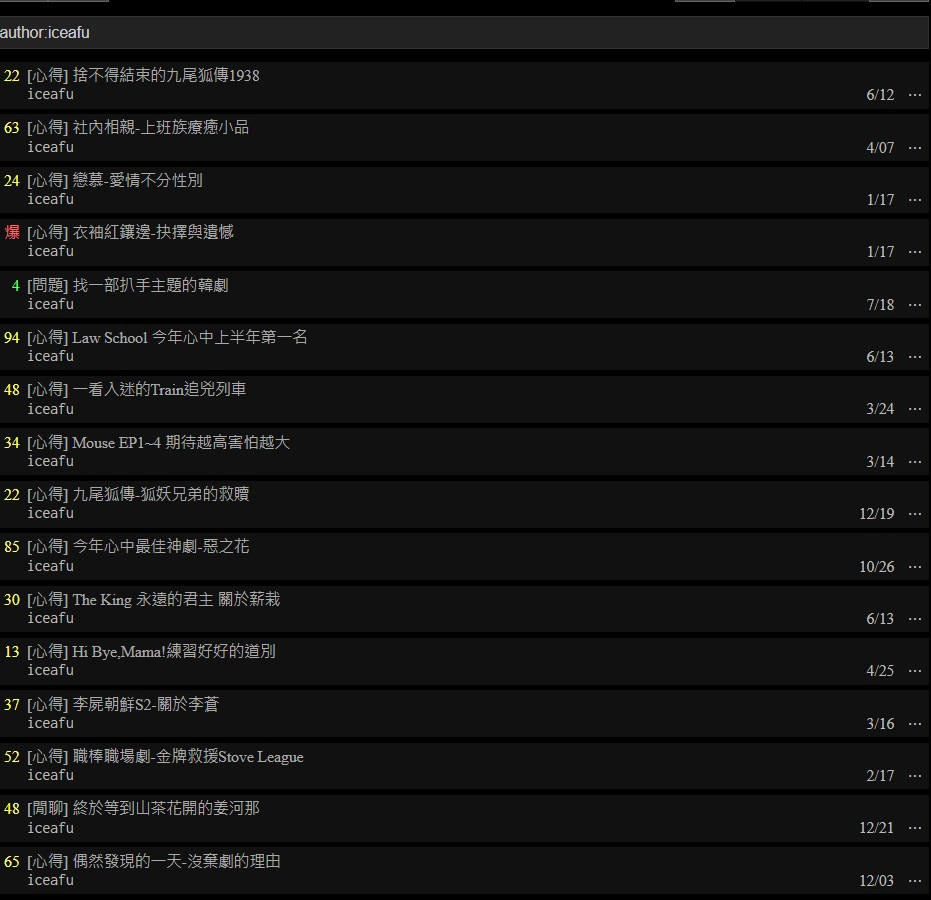

In [ ]:
Image(filename='ptt3.jpg')

我們發現此用戶iceafu多是發佈一些劇集心得，並且從每篇文章標題前的數字可以發現其貼文幾乎都受到熱烈的正向回應(數字表示該則文章留言中推文-噓文的數量)，實為此版面的關鍵人物。

### Graph評估

Transitivity

In [ ]:
nx.transitivity(nx.Graph(sub_mat))

0.00023037714658705855

由於節點太多, 不會出現太多closure。

Density

In [ ]:
nx.density(nx.Graph(sub_mat))

0.0023369209728251175

Density 也是合理, node那麼多, 但大多數都只會連上文章

Diameter

In [ ]:
nx.diameter(nx.Graph(sub_mat))

5

Diameter 是5, 代表最遠的兩個node 之間只間隔了5個點, 是符合 Small World Graph的。

Average shortest path

In [ ]:
nx.average_shortest_path_length(nx.Graph(sub_mat))

3.571984698023825

Clustering

In [ ]:
nx.average_clustering(nx.Graph(sub_mat))

0.0011980022927545692

## 5. 總結

經過以上分析，我們有了以下發現:
+ 在這段時間內，PTT韓劇版上有大量對「二十五。二十一」、「淚之女王」、「衣袖紅鑲邊」、「社內相親」的討論，且討論多聚焦在主角上，而實際到PPT上觀察也可以發現很多有關主角們的分析與心得文。由此可知，對韓劇版的網友而言，這四部劇可以說是值得追的韓劇，且對主角們的塑造也算成功，能引起網友的討論。
+ 相比復仇、痛苦類型，大眾較為偏好帶有正面情緒的韓劇，正向情緒詞被頻繁提及。
+ 可以藉由與主角名稱的高頻率且高相關性詞彙，大致了解一個角色的身分、個性與相關劇情。能在尚未追劇的情況下先對一部劇的走向與風格有一定的認知。
+ 根據LDA的分群結果可以發現版友對負面結局的熱烈討論。
+ PTT韓劇版的對韓劇的討論熱烈，包含對劇情與角色的不同看法。用戶經常在多個貼文下留言且時常出現兩派爭論的情況也間接說明韓劇版使用者間的踴躍互動。
+ 有部分用戶為韓劇版的關鍵評論者，常常發布韓劇的觀後心得文，且能引發其他用戶的回響。
